## 1.Logistic regression overivew

#### 1.1 sigmoid function

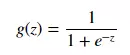


- g:ℝ→[0,1] (值域是0到1)
- g(0)=0.5 (当x=0时,y=0.5)
- g(−∞)=0 (当x趋于负无穷时,y=0)
- g(+∞)=1 (当x趋于正无穷时,y=1)




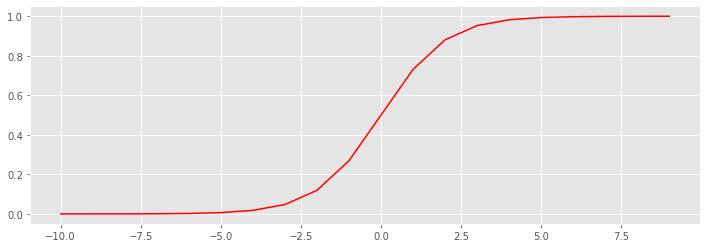

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline 

def sigmoid(z):
    return 1/(1+np.exp(-z))

nums=np.arange(-10,10,step=1)
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(nums,sigmoid(nums),"r")

#### 1.2 Functions（model）

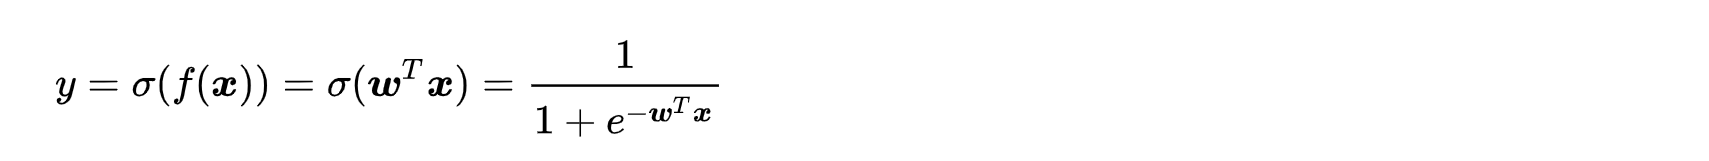

- w weight, hyperparameters
- x input features
- y predictions


#### 1.3 loss function

Cross Entropy Error Function

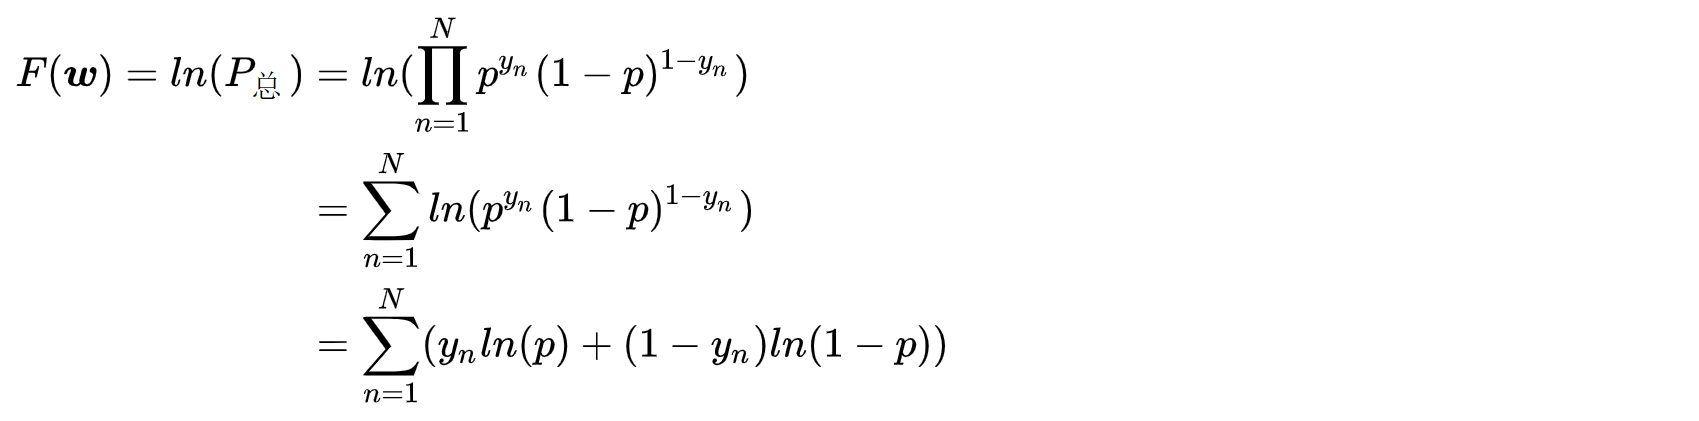



## 2. 面向模型的数据预处理

经过上次课程在“3.特征提取.ipynb”做特征构建之后，在对特征数据样本套用模型进行分类预测之前，还需要根据具体所采用的模型对数据进行二次预处理，下面讨论其中重要的几点：

- 正负样本失衡问题

经过特征构建所得的数据集正负样本比例约为 1：120，数据严重失衡，易导致模型训练失效。在这里，我们可通过下采样和基于 f1_score 的评价标准来应对此问题。

若考虑对训练集中的负样本进行下采样。为避免随机采样的特征空间覆盖性不足，先对负样本进行k-means聚类，然后在每个聚类上采用subsample来获得全面的负样本采样，最后与正样本组成较为平衡的训练集。

- 缺失值问题

在所构建的特征中，一些特征存在缺失值（如xx_diff_hours），这里，采用移除缺失值特征的数据集进行LR模型的训练，采用将缺失值赋值为-1的训练集进行RF/GBDT模型的训练。

- 归一化问题

在进行k-means和LR时，需要对不同度量尺度的特征进行归一化处理，这里我们采用sklearn.preprocessing.StandardScaler()实现。


代码实现：

# K-means

In [11]:
'''
@author: PY131

@thoughts:  as the samples are extremely imbalance (N/P ratio ~ 1.2k),
            here we use sub-sample on negative samples.
            1-st: using k_means to make clustering on negative samples (clusters_number ~ 1k)
            2-nd: subsample on each clusters based on the same ratio,
                  the ratio was selected to be the best by testing in random sub_sample + GBDT
            3-rd: using GBDT model for training and predicting on sub_sample set.
            
            here is 1-st step

@Description:
    here we use clustering to data reduction: 
        we want to get N/P ration ~ 35 for each training set
        the method refer to:
            https://www.quora.com/In-classification-how-do-you-handle-an-unbalanced-training-set/answers/1144228?spm=5176.100239.blogcont93547.8.UsslUB&srid=h3G6o

'''

'\n@author: PY131\n\n@thoughts:  as the samples are extremely imbalance (N/P ratio ~ 1.2k),\n            here we use sub-sample on negative samples.\n            1-st: using k_means to make clustering on negative samples (clusters_number ~ 1k)\n            2-nd: subsample on each clusters based on the same ratio,\n                  the ratio was selected to be the best by testing in random sub_sample + GBDT\n            3-rd: using GBDT model for training and predicting on sub_sample set.\n            \n            here is 1-st step\n\n@Description:\n    here we use clustering to data reduction: \n        we want to get N/P ration ~ 35 for each training set\n        the method refer to:\n            https://www.quora.com/In-classification-how-do-you-handle-an-unbalanced-training-set/answers/1144228?spm=5176.100239.blogcont93547.8.UsslUB&srid=h3G6o\n\n'

In [2]:
##### file path
### input
# data_set keys and lebels
path_df_part_1_uic_label = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/df_part_1_uic_label.csv"
path_df_part_2_uic_label = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/df_part_2_uic_label.csv"
path_df_part_3_uic       = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/df_part_3_uic.csv"

# data_set features
path_df_part_1_U   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_1_U.csv"  
path_df_part_1_I   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_1_I.csv"
path_df_part_1_C   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_1_C.csv"
path_df_part_1_IC  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_1_IC.csv"
path_df_part_1_UI  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_1_UI.csv"
path_df_part_1_UC  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_1_UC.csv"

path_df_part_2_U   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_2_U.csv"  
path_df_part_2_I   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_2_I.csv"
path_df_part_2_C   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_2_C.csv"
path_df_part_2_IC  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_2_IC.csv"
path_df_part_2_UI  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_2_UI.csv"
path_df_part_2_UC  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_2_UC.csv"

path_df_part_3_U   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_3_U.csv"  
path_df_part_3_I   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_3_I.csv"
path_df_part_3_C   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_3_C.csv"
path_df_part_3_IC  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_3_IC.csv"
path_df_part_3_UI  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_3_UI.csv"
path_df_part_3_UC  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_3_UC.csv"

### out file

### intermediate file
# data partition with diffferent label
path_df_part_1_uic_label_0 = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/df_part_1_uic_label_0.csv"
path_df_part_1_uic_label_1 = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/df_part_1_uic_label_1.csv"
path_df_part_2_uic_label_0 = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/df_part_2_uic_label_0.csv"
path_df_part_2_uic_label_1 = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/df_part_2_uic_label_1.csv"

# training set keys uic-label with k_means clusters' label
path_df_part_1_uic_label_cluster = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/df_part_1_uic_label_cluster.csv"
path_df_part_2_uic_label_cluster = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/df_part_2_uic_label_cluster.csv"

# scalers for data standardization store as python pickle
# for each part's features
path_df_part_1_scaler = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/df_part_1_scaler"
path_df_part_2_scaler = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/df_part_2_scaler"

In [3]:
import pandas as pd
import numpy as np

def df_read(path, mode = 'r'):
    '''the definition of dataframe loading function 
    '''
    path_df = open(path, mode)
    try:     df = pd.read_csv(path_df, index_col = False)
    finally: path_df.close()
    return   df

def subsample(df, sub_size):
    '''the definition of sub-sampling function
    @param df: dataframe
    @param sub_size: sub_sample set size
    
    @return sub-dataframe with the same formation of df
    '''
    if sub_size >= len(df) : return df
    else : return df.sample(n = sub_size)
    

In [4]:
'''Step 1: dividing of positive and negative sub-set by u-i-c-label keys
    
    p.s. we first generate u-i-C key, then merging for data set and operation by chunk 
    such strange operation designed for saving my poor PC-MEM.
'''

print("0/1 positive negative differentiation save seperately @ %s, %s, %s, %s" % 
    (path_df_part_1_uic_label_0,path_df_part_1_uic_label_1,path_df_part_2_uic_label_0,path_df_part_2_uic_label_1))

df_part_1_uic_label = df_read(path_df_part_1_uic_label)  # loading total keys
df_part_2_uic_label = df_read(path_df_part_2_uic_label)

df_part_1_uic_label_0 = df_part_1_uic_label[df_part_1_uic_label['label'] == 0]
df_part_1_uic_label_1 = df_part_1_uic_label[df_part_1_uic_label['label'] == 1]
df_part_2_uic_label_0 = df_part_2_uic_label[df_part_2_uic_label['label'] == 0]
df_part_2_uic_label_1 = df_part_2_uic_label[df_part_2_uic_label['label'] == 1]

df_part_1_uic_label_0.to_csv(path_df_part_1_uic_label_0, index=False)
df_part_1_uic_label_1.to_csv(path_df_part_1_uic_label_1, index=False)
df_part_2_uic_label_0.to_csv(path_df_part_2_uic_label_0, index=False)
df_part_2_uic_label_1.to_csv(path_df_part_2_uic_label_1, index=False)

# release memeory
del(df_part_1_uic_label)
del(df_part_2_uic_label)
del(df_part_1_uic_label_0)
del(df_part_1_uic_label_1)
del(df_part_2_uic_label_0)
del(df_part_2_uic_label_1)

print("process 1 done)

0/1 positive negative differentiation save seperately @ /Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/df_part_1_uic_label_0.csv, /Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/df_part_1_uic_label_1.csv, /Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/df_part_2_uic_label_0.csv, /Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/df_part_2_uic_label_1.csv
process 1 done。


In [5]:
#######################################################################
'''Step 2: clustering on negative sub-set
    clusters number ~ 35, using mini-batch-k-means
'''

print(' process 2 cluster part 1 and part 1 negative sample using k-mean')

 process 2 cluster part 1 and part 1 negative sample using k-mean


In [6]:
from sklearn import preprocessing
from sklearn.cluster import MiniBatchKMeans
import pickle

In [7]:
##### part_1 #####
print("process part 1 data")
# loading features
df_part_1_U  = df_read(path_df_part_1_U )   
df_part_1_I  = df_read(path_df_part_1_I )
df_part_1_C  = df_read(path_df_part_1_C )
df_part_1_IC = df_read(path_df_part_1_IC)
df_part_1_UI = df_read(path_df_part_1_UI)
df_part_1_UC = df_read(path_df_part_1_UC)

# process by chunk as ui-pairs size is too big

# for get scale transform mechanism to large scale of data
scaler_1 = preprocessing.StandardScaler() 
batch = 0
for df_part_1_uic_label_0 in pd.read_csv(open(path_df_part_1_uic_label_0, 'r'), chunksize=150000): 
    try:
        # construct of part_1's sub-training set
        train_data_df_part_1 = pd.merge(df_part_1_uic_label_0, df_part_1_U, how='left', on=['user_id'])
        train_data_df_part_1 = pd.merge(train_data_df_part_1, df_part_1_I,  how='left', on=['item_id'])
        train_data_df_part_1 = pd.merge(train_data_df_part_1, df_part_1_C,  how='left', on=['item_category'])
        train_data_df_part_1 = pd.merge(train_data_df_part_1, df_part_1_IC, how='left', on=['item_id','item_category'])
        train_data_df_part_1 = pd.merge(train_data_df_part_1, df_part_1_UI, how='left', on=['user_id','item_id','item_category','label'])
        train_data_df_part_1 = pd.merge(train_data_df_part_1, df_part_1_UC, how='left', on=['user_id','item_category'])

        # print(train_data_df_part_1.head())
        
        # getting all the complete features for clustering
        train_X_1 = train_data_df_part_1[['u_b1_count_in_6','u_b2_count_in_6','u_b3_count_in_6','u_b4_count_in_6','u_b_count_in_6', 
                                                    'u_b1_count_in_3','u_b2_count_in_3','u_b3_count_in_3','u_b4_count_in_3','u_b_count_in_3', 
                                                    'u_b1_count_in_1','u_b2_count_in_1','u_b3_count_in_1','u_b4_count_in_1','u_b_count_in_1', 
                                                    'u_b4_rate',
                                                    'i_u_count_in_6','i_u_count_in_3','i_u_count_in_1',
                                                    'i_b1_count_in_6','i_b2_count_in_6','i_b3_count_in_6','i_b4_count_in_6','i_b_count_in_6', 
                                                    'i_b1_count_in_3','i_b2_count_in_3','i_b3_count_in_3','i_b4_count_in_3','i_b_count_in_3',
                                                    'i_b1_count_in_1','i_b2_count_in_1','i_b3_count_in_1','i_b4_count_in_1','i_b_count_in_1', 
                                                    'i_b4_rate',
                                                    'c_b1_count_in_6','c_b2_count_in_6','c_b3_count_in_6','c_b4_count_in_6','c_b_count_in_6',
                                                    'c_b1_count_in_3','c_b2_count_in_3','c_b3_count_in_3','c_b4_count_in_3','c_b_count_in_3',
                                                    'c_b1_count_in_1','c_b2_count_in_1','c_b3_count_in_1','c_b4_count_in_1','c_b_count_in_1',
                                                    'c_b4_rate',
                                                    'ic_u_rank_in_c','ic_b_rank_in_c','ic_b4_rank_in_c', 
                                                    'ui_b1_count_in_6','ui_b2_count_in_6','ui_b3_count_in_6','ui_b4_count_in_6','ui_b_count_in_6',
                                                    'ui_b1_count_in_3','ui_b2_count_in_3','ui_b3_count_in_3','ui_b4_count_in_3','ui_b_count_in_3',
                                                    'ui_b1_count_in_1','ui_b2_count_in_1','ui_b3_count_in_1','ui_b4_count_in_1','ui_b_count_in_1', 
                                                    'ui_b_count_rank_in_u','ui_b_count_rank_in_uc',
                                                    'uc_b1_count_in_6','uc_b2_count_in_6','uc_b3_count_in_6','uc_b4_count_in_6','uc_b_count_in_6', 
                                                    'uc_b1_count_in_3','uc_b2_count_in_3','uc_b3_count_in_3','uc_b4_count_in_3','uc_b_count_in_3', 
                                                    'uc_b1_count_in_1','uc_b2_count_in_1','uc_b3_count_in_1','uc_b4_count_in_1','uc_b_count_in_1',
                                                    'uc_b_count_rank_in_u']].values
        # feature standardization
        scaler_1.partial_fit(train_X_1)        
        
        batch += 1
        print('chunk %d done.' %batch) 
        
    except StopIteration:
        print("finish.")
        break

print("part 1 processed data read")

# initial clusters

print("k-mean cluster part 1")
# 聚类，分为1000类
mbk_1 = MiniBatchKMeans(init='k-means++', n_clusters=1000, batch_size=500, reassignment_ratio=10**-4) 
classes_1 = []
batch = 0
for df_part_1_uic_label_0 in pd.read_csv(open(path_df_part_1_uic_label_0, 'r'), chunksize=15000): 
    try:
        # construct of part_1's sub-training set
        train_data_df_part_1 = pd.merge(df_part_1_uic_label_0, df_part_1_U, how='left', on=['user_id'])
        train_data_df_part_1 = pd.merge(train_data_df_part_1, df_part_1_I,  how='left', on=['item_id'])
        train_data_df_part_1 = pd.merge(train_data_df_part_1, df_part_1_C,  how='left', on=['item_category'])
        train_data_df_part_1 = pd.merge(train_data_df_part_1, df_part_1_IC, how='left', on=['item_id','item_category'])
        train_data_df_part_1 = pd.merge(train_data_df_part_1, df_part_1_UI, how='left', on=['user_id','item_id','item_category','label'])
        train_data_df_part_1 = pd.merge(train_data_df_part_1, df_part_1_UC, how='left', on=['user_id','item_category'])
        
        train_X_1 = train_data_df_part_1[['u_b1_count_in_6','u_b2_count_in_6','u_b3_count_in_6','u_b4_count_in_6','u_b_count_in_6', 
                                                    'u_b1_count_in_3','u_b2_count_in_3','u_b3_count_in_3','u_b4_count_in_3','u_b_count_in_3', 
                                                    'u_b1_count_in_1','u_b2_count_in_1','u_b3_count_in_1','u_b4_count_in_1','u_b_count_in_1', 
                                                    'u_b4_rate',
                                                    'i_u_count_in_6','i_u_count_in_3','i_u_count_in_1',
                                                    'i_b1_count_in_6','i_b2_count_in_6','i_b3_count_in_6','i_b4_count_in_6','i_b_count_in_6', 
                                                    'i_b1_count_in_3','i_b2_count_in_3','i_b3_count_in_3','i_b4_count_in_3','i_b_count_in_3',
                                                    'i_b1_count_in_1','i_b2_count_in_1','i_b3_count_in_1','i_b4_count_in_1','i_b_count_in_1', 
                                                    'i_b4_rate',
                                                    'c_b1_count_in_6','c_b2_count_in_6','c_b3_count_in_6','c_b4_count_in_6','c_b_count_in_6',
                                                    'c_b1_count_in_3','c_b2_count_in_3','c_b3_count_in_3','c_b4_count_in_3','c_b_count_in_3',
                                                    'c_b1_count_in_1','c_b2_count_in_1','c_b3_count_in_1','c_b4_count_in_1','c_b_count_in_1',
                                                    'c_b4_rate',
                                                    'ic_u_rank_in_c','ic_b_rank_in_c','ic_b4_rank_in_c', 
                                                    'ui_b1_count_in_6','ui_b2_count_in_6','ui_b3_count_in_6','ui_b4_count_in_6','ui_b_count_in_6',
                                                    'ui_b1_count_in_3','ui_b2_count_in_3','ui_b3_count_in_3','ui_b4_count_in_3','ui_b_count_in_3',
                                                    'ui_b1_count_in_1','ui_b2_count_in_1','ui_b3_count_in_1','ui_b4_count_in_1','ui_b_count_in_1', 
                                                    'ui_b_count_rank_in_u','ui_b_count_rank_in_uc',
                                                    'uc_b1_count_in_6','uc_b2_count_in_6','uc_b3_count_in_6','uc_b4_count_in_6','uc_b_count_in_6', 
                                                    'uc_b1_count_in_3','uc_b2_count_in_3','uc_b3_count_in_3','uc_b4_count_in_3','uc_b_count_in_3', 
                                                    'uc_b1_count_in_1','uc_b2_count_in_1','uc_b3_count_in_1','uc_b4_count_in_1','uc_b_count_in_1',
                                                    'uc_b_count_rank_in_u']].values
        # feature standardization
        standardized_train_X_1 = scaler_1.transform(train_X_1)
         
        # fit clustering model
        mbk_1.partial_fit(standardized_train_X_1)
        classes_1 = np.append(classes_1, mbk_1.labels_)
        
        batch += 1
        print('chunk %d done.' %batch) 
        
    except StopIteration:
        print(" ------------ k-means finished on part 1 ------------.")
        break 

# 释放内存
del(df_part_1_U )
del(df_part_1_I )
del(df_part_1_C )
del(df_part_1_IC)
del(df_part_1_UI)
del(df_part_1_UC)

print("K-mean cluster part 1 done 。")

process part 1 data
chunk 1 done.
chunk 2 done.
chunk 3 done.
chunk 4 done.
chunk 5 done.
chunk 6 done.
chunk 7 done.
chunk 8 done.
chunk 9 done.
chunk 10 done.
chunk 11 done.
chunk 12 done.
part 1 processed data read
k-mean cluster part 1
chunk 1 done.
chunk 2 done.
chunk 3 done.
chunk 4 done.
chunk 5 done.
chunk 6 done.
chunk 7 done.
chunk 8 done.
chunk 9 done.
chunk 10 done.
chunk 11 done.
chunk 12 done.
chunk 13 done.
chunk 14 done.
chunk 15 done.
chunk 16 done.
chunk 17 done.
chunk 18 done.
chunk 19 done.
chunk 20 done.
chunk 21 done.
chunk 22 done.
chunk 23 done.
chunk 24 done.
chunk 25 done.
chunk 26 done.
chunk 27 done.
chunk 28 done.
chunk 29 done.
chunk 30 done.
chunk 31 done.
chunk 32 done.
chunk 33 done.
chunk 34 done.
chunk 35 done.
chunk 36 done.
chunk 37 done.
chunk 38 done.
chunk 39 done.
chunk 40 done.
chunk 41 done.
chunk 42 done.
chunk 43 done.
chunk 44 done.
chunk 45 done.
chunk 46 done.
chunk 47 done.
chunk 48 done.
chunk 49 done.
chunk 50 done.
chunk 51 done.
chun

In [8]:
##### part_2 #####
print("process 2 part 2 data")
# loading features
df_part_2_U  = df_read(path_df_part_2_U )   
df_part_2_I  = df_read(path_df_part_2_I )
df_part_2_C  = df_read(path_df_part_2_C )
df_part_2_IC = df_read(path_df_part_2_IC)
df_part_2_UI = df_read(path_df_part_2_UI)
df_part_2_UC = df_read(path_df_part_2_UC)

# process by chunk as ui-pairs size is too big

# for get scale transform mechanism to large scale of data
scaler_2 = preprocessing.StandardScaler()
batch = 0
for df_part_2_uic_label_0 in pd.read_csv(open(path_df_part_2_uic_label_0, 'r'), chunksize=150000): 
    try:
        # construct of part_1's sub-training set
        train_data_df_part_2 = pd.merge(df_part_2_uic_label_0, df_part_2_U, how='left', on=['user_id'])
        train_data_df_part_2 = pd.merge(train_data_df_part_2, df_part_2_I,  how='left', on=['item_id'])
        train_data_df_part_2 = pd.merge(train_data_df_part_2, df_part_2_C,  how='left', on=['item_category'])
        train_data_df_part_2 = pd.merge(train_data_df_part_2, df_part_2_IC, how='left', on=['item_id','item_category'])
        train_data_df_part_2 = pd.merge(train_data_df_part_2, df_part_2_UI, how='left', on=['user_id','item_id','item_category','label'])
        train_data_df_part_2 = pd.merge(train_data_df_part_2, df_part_2_UC, how='left', on=['user_id','item_category'])

        train_X_2 = train_data_df_part_2[['u_b1_count_in_6','u_b2_count_in_6','u_b3_count_in_6','u_b4_count_in_6','u_b_count_in_6', 
                                                    'u_b1_count_in_3','u_b2_count_in_3','u_b3_count_in_3','u_b4_count_in_3','u_b_count_in_3', 
                                                    'u_b1_count_in_1','u_b2_count_in_1','u_b3_count_in_1','u_b4_count_in_1','u_b_count_in_1', 
                                                    'u_b4_rate',
                                                    'i_u_count_in_6','i_u_count_in_3','i_u_count_in_1',
                                                    'i_b1_count_in_6','i_b2_count_in_6','i_b3_count_in_6','i_b4_count_in_6','i_b_count_in_6', 
                                                    'i_b1_count_in_3','i_b2_count_in_3','i_b3_count_in_3','i_b4_count_in_3','i_b_count_in_3',
                                                    'i_b1_count_in_1','i_b2_count_in_1','i_b3_count_in_1','i_b4_count_in_1','i_b_count_in_1', 
                                                    'i_b4_rate',
                                                    'c_b1_count_in_6','c_b2_count_in_6','c_b3_count_in_6','c_b4_count_in_6','c_b_count_in_6',
                                                    'c_b1_count_in_3','c_b2_count_in_3','c_b3_count_in_3','c_b4_count_in_3','c_b_count_in_3',
                                                    'c_b1_count_in_1','c_b2_count_in_1','c_b3_count_in_1','c_b4_count_in_1','c_b_count_in_1',
                                                    'c_b4_rate',
                                                    'ic_u_rank_in_c','ic_b_rank_in_c','ic_b4_rank_in_c', 
                                                    'ui_b1_count_in_6','ui_b2_count_in_6','ui_b3_count_in_6','ui_b4_count_in_6','ui_b_count_in_6',
                                                    'ui_b1_count_in_3','ui_b2_count_in_3','ui_b3_count_in_3','ui_b4_count_in_3','ui_b_count_in_3',
                                                    'ui_b1_count_in_1','ui_b2_count_in_1','ui_b3_count_in_1','ui_b4_count_in_1','ui_b_count_in_1', 
                                                    'ui_b_count_rank_in_u','ui_b_count_rank_in_uc',
                                                    'uc_b1_count_in_6','uc_b2_count_in_6','uc_b3_count_in_6','uc_b4_count_in_6','uc_b_count_in_6', 
                                                    'uc_b1_count_in_3','uc_b2_count_in_3','uc_b3_count_in_3','uc_b4_count_in_3','uc_b_count_in_3', 
                                                    'uc_b1_count_in_1','uc_b2_count_in_1','uc_b3_count_in_1','uc_b4_count_in_1','uc_b_count_in_1',
                                                    'uc_b_count_rank_in_u']].values
        # fit the scaler
        scaler_2.partial_fit(train_X_2)
        
        batch += 1
        print('chunk %d done.' %batch) 
        
    except StopIteration:
        print("finish.")
        break 


print("part 2 data read")

# initial clusters
print("k-mean cluster part 2")

mbk_2 = MiniBatchKMeans(init='k-means++', n_clusters=1000, batch_size=500, reassignment_ratio=10**-4)  

# process by chunk as ui-pairs size is too big
batch = 0
classes_2 = []
for df_part_2_uic_label_0 in pd.read_csv(open(path_df_part_2_uic_label_0, 'r'), chunksize=15000): 
    try:
        # construct of part_1's sub-training set
        train_data_df_part_2 = pd.merge(df_part_2_uic_label_0, df_part_2_U, how='left', on=['user_id'])
        train_data_df_part_2 = pd.merge(train_data_df_part_2, df_part_2_I,  how='left', on=['item_id'])
        train_data_df_part_2 = pd.merge(train_data_df_part_2, df_part_2_C,  how='left', on=['item_category'])
        train_data_df_part_2 = pd.merge(train_data_df_part_2, df_part_2_IC, how='left', on=['item_id','item_category'])
        train_data_df_part_2 = pd.merge(train_data_df_part_2, df_part_2_UI, how='left', on=['user_id','item_id','item_category','label'])
        train_data_df_part_2 = pd.merge(train_data_df_part_2, df_part_2_UC, how='left', on=['user_id','item_category'])
        
        train_X_2 = train_data_df_part_2[['u_b1_count_in_6','u_b2_count_in_6','u_b3_count_in_6','u_b4_count_in_6','u_b_count_in_6', 
                                                    'u_b1_count_in_3','u_b2_count_in_3','u_b3_count_in_3','u_b4_count_in_3','u_b_count_in_3', 
                                                    'u_b1_count_in_1','u_b2_count_in_1','u_b3_count_in_1','u_b4_count_in_1','u_b_count_in_1', 
                                                    'u_b4_rate',
                                                    'i_u_count_in_6','i_u_count_in_3','i_u_count_in_1',
                                                    'i_b1_count_in_6','i_b2_count_in_6','i_b3_count_in_6','i_b4_count_in_6','i_b_count_in_6', 
                                                    'i_b1_count_in_3','i_b2_count_in_3','i_b3_count_in_3','i_b4_count_in_3','i_b_count_in_3',
                                                    'i_b1_count_in_1','i_b2_count_in_1','i_b3_count_in_1','i_b4_count_in_1','i_b_count_in_1', 
                                                    'i_b4_rate',
                                                    'c_b1_count_in_6','c_b2_count_in_6','c_b3_count_in_6','c_b4_count_in_6','c_b_count_in_6',
                                                    'c_b1_count_in_3','c_b2_count_in_3','c_b3_count_in_3','c_b4_count_in_3','c_b_count_in_3',
                                                    'c_b1_count_in_1','c_b2_count_in_1','c_b3_count_in_1','c_b4_count_in_1','c_b_count_in_1',
                                                    'c_b4_rate',
                                                    'ic_u_rank_in_c','ic_b_rank_in_c','ic_b4_rank_in_c', 
                                                    'ui_b1_count_in_6','ui_b2_count_in_6','ui_b3_count_in_6','ui_b4_count_in_6','ui_b_count_in_6',
                                                    'ui_b1_count_in_3','ui_b2_count_in_3','ui_b3_count_in_3','ui_b4_count_in_3','ui_b_count_in_3',
                                                    'ui_b1_count_in_1','ui_b2_count_in_1','ui_b3_count_in_1','ui_b4_count_in_1','ui_b_count_in_1', 
                                                    'ui_b_count_rank_in_u','ui_b_count_rank_in_uc',
                                                    'uc_b1_count_in_6','uc_b2_count_in_6','uc_b3_count_in_6','uc_b4_count_in_6','uc_b_count_in_6', 
                                                    'uc_b1_count_in_3','uc_b2_count_in_3','uc_b3_count_in_3','uc_b4_count_in_3','uc_b_count_in_3', 
                                                    'uc_b1_count_in_1','uc_b2_count_in_1','uc_b3_count_in_1','uc_b4_count_in_1','uc_b_count_in_1',
                                                    'uc_b_count_rank_in_u']].values
        # feature standardization
        standardized_train_X_2 = scaler_2.transform(train_X_2)
        
        # fit clustering model
        mbk_2.partial_fit(standardized_train_X_2)
        classes_2 = np.append(classes_2, mbk_2.labels_)
        
        batch += 1
        print('chunk %d done.' %batch) 
        
    except StopIteration:
        print(" ------------ k-means finished on part 2 ------------.")
        break 

del(df_part_2_U )
del(df_part_2_I )
del(df_part_2_C )
del(df_part_2_IC)
del(df_part_2_UI)
del(df_part_2_UC)

pickle.dump(scaler_1, open(path_df_part_1_scaler,'wb')) 
pickle.dump(scaler_2, open(path_df_part_2_scaler,'wb'))
print("K-mean cluster part 2 done")

process 2 part 2 data
chunk 1 done.
chunk 2 done.
chunk 3 done.
chunk 4 done.
chunk 5 done.
chunk 6 done.
chunk 7 done.
chunk 8 done.
chunk 9 done.
chunk 10 done.
chunk 11 done.
chunk 12 done.
chunk 13 done.
part 2 data read
k-mean cluster part 2
chunk 1 done.
chunk 2 done.
chunk 3 done.
chunk 4 done.
chunk 5 done.
chunk 6 done.
chunk 7 done.
chunk 8 done.
chunk 9 done.
chunk 10 done.
chunk 11 done.
chunk 12 done.
chunk 13 done.
chunk 14 done.
chunk 15 done.
chunk 16 done.
chunk 17 done.
chunk 18 done.
chunk 19 done.
chunk 20 done.
chunk 21 done.
chunk 22 done.
chunk 23 done.
chunk 24 done.
chunk 25 done.
chunk 26 done.
chunk 27 done.
chunk 28 done.
chunk 29 done.
chunk 30 done.
chunk 31 done.
chunk 32 done.
chunk 33 done.
chunk 34 done.
chunk 35 done.
chunk 36 done.
chunk 37 done.
chunk 38 done.
chunk 39 done.
chunk 40 done.
chunk 41 done.
chunk 42 done.
chunk 43 done.
chunk 44 done.
chunk 45 done.
chunk 46 done.
chunk 47 done.
chunk 48 done.
chunk 49 done.
chunk 50 done.
chunk 51 don

In [9]:
'''Step 3: generation of new training set

    each training sub-set contains a clusters' negative samples' and all positive samples
    
    here we just generation of u-i-c-label-class keys of training data 
        ps. label -> whether to buy
            class -> clusters labels 
                for positive : 0
                for negitive : 1 to clusters_numbers
'''


# add a new attr for keys
df_part_1_uic_label_0 = df_read(path_df_part_1_uic_label_0)
df_part_1_uic_label_1 = df_read(path_df_part_1_uic_label_1)
df_part_2_uic_label_0 = df_read(path_df_part_2_uic_label_0)
df_part_2_uic_label_1 = df_read(path_df_part_2_uic_label_1)
    
df_part_1_uic_label_0['class'] = classes_1.astype('int') + 1
df_part_1_uic_label_1['class'] = 0
df_part_2_uic_label_0['class'] = classes_2.astype('int') + 1
df_part_2_uic_label_1['class'] = 0

df_part_1_uic_label_class = pd.concat([df_part_1_uic_label_0, df_part_1_uic_label_1])
df_part_2_uic_label_class = pd.concat([df_part_2_uic_label_0, df_part_2_uic_label_1])
   
df_part_1_uic_label_class.to_csv(path_df_part_1_uic_label_cluster, index=False)
df_part_2_uic_label_class.to_csv(path_df_part_2_uic_label_cluster, index=False)

print("save to %s,%s"
        % (path_df_part_1_uic_label_cluster, path_df_part_2_uic_label_cluster))

save to /Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/df_part_1_uic_label_cluster.csv,/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/df_part_2_uic_label_cluster.csv


In [1]:
%run model\k_means_preprocessing.py

第一步开始区分0/1正负样本，分开存储到 ../data/mobile/k_means_subsample/df_part_1_uic_label_0.csv, ../data/mobile/k_means_subsample/df_part_1_uic_label_1.csv, ../data/mobile/k_means_subsample/df_part_2_uic_label_0.csv, ../data/mobile/k_means_subsample/df_part_2_uic_label_1.csv
第一步处理完成。
第二步，开始针对part1和part2的数据的负样本，使用k-means做负采样
第二步中，处理part1数据
chunk 1 done.
chunk 2 done.
chunk 3 done.
chunk 4 done.
chunk 5 done.
chunk 6 done.
chunk 7 done.
chunk 8 done.
chunk 9 done.
chunk 10 done.
chunk 11 done.
chunk 12 done.
第二步中，处理part1数据，数据预读完成
第二步中，处理part1数据，开始kmeans聚类
chunk 1 done.
chunk 2 done.
chunk 3 done.
chunk 4 done.
chunk 5 done.
chunk 6 done.
chunk 7 done.
chunk 8 done.
chunk 9 done.
chunk 10 done.
chunk 11 done.
chunk 12 done.
chunk 13 done.
chunk 14 done.
chunk 15 done.
chunk 16 done.
chunk 17 done.
chunk 18 done.
chunk 19 done.
chunk 20 done.
chunk 21 done.
chunk 22 done.
chunk 23 done.
chunk 24 done.
chunk 25 done.
chunk 26 done.
chunk 27 done.
chunk 28 done.
chunk 29 done.
chunk 30 done.
chunk 31 done.


# 3.LR model

In [ ]:
# core codes

"""
# -train
train_X, train_y = train_set_construct(np_ratio=35, sub_ratio=1)

# build model and fitting
LR_clf = LogisticRegression(verbose=True)
LR_clf.fit(train_X, train_y)


# predicting
# feature standardization
standardized_pred_X = scaler_3.transform(pred_X)
pred_y = (LR_clf.predict_proba(standardized_predX)[:,1] > 0.5).astype('int')
"""

In [4]:
%run model\lr_on_subsample.py

prediction chunk 1 done.
prediction chunk 2 done.
prediction chunk 3 done.
prediction chunk 4 done.
prediction chunk 5 done.
prediction chunk 6 done.
prediction chunk 7 done.
prediction chunk 8 done.
prediction chunk 9 done.
prediction chunk 10 done.
prediction chunk 11 done.
prediction chunk 12 done.
prediction chunk 13 done.
prediction chunk 14 done.
prediction chunk 15 done.
prediction chunk 16 done.
prediction chunk 17 done.
prediction chunk 18 done.
prediction chunk 19 done.
training subset uic_label keys is selected.
train subset is generated.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\kang\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


prediction chunk 1 done.
prediction chunk 2 done.
prediction chunk 3 done.
prediction chunk 4 done.
prediction chunk 5 done.
prediction chunk 6 done.
prediction chunk 7 done.
prediction chunk 8 done.
prediction chunk 9 done.
prediction chunk 10 done.
prediction chunk 11 done.
prediction chunk 12 done.
prediction chunk 13 done.
prediction chunk 14 done.
prediction chunk 15 done.
prediction chunk 16 done.
prediction chunk 17 done.
prediction chunk 18 done.
prediction chunk 19 done.
 完成。 


In [10]:
##### file path
### input
# data_set keys and lebels
path_df_part_1_uic_label = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/df_part_1_uic_label.csv"
path_df_part_2_uic_label = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/df_part_2_uic_label.csv"
path_df_part_3_uic       = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/df_part_3_uic.csv"

# data_set features
path_df_part_1_U   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_1_U.csv"  
path_df_part_1_I   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_1_I.csv"
path_df_part_1_C   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_1_C.csv"
path_df_part_1_IC  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_1_IC.csv"
path_df_part_1_UI  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_1_UI.csv"
path_df_part_1_UC  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_1_UC.csv"

path_df_part_2_U   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_2_U.csv"  
path_df_part_2_I   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_2_I.csv"
path_df_part_2_C   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_2_C.csv"
path_df_part_2_IC  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_2_IC.csv"
path_df_part_2_UI  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_2_UI.csv"
path_df_part_2_UC  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_2_UC.csv"

path_df_part_3_U   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_3_U.csv"  
path_df_part_3_I   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_3_I.csv"
path_df_part_3_C   = "/Users/DanDan/Desktop/第一课/code/feature/df_part_3_C.csv"
path_df_part_3_IC  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_3_IC.csv"
path_df_part_3_UI  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_3_UI.csv"
path_df_part_3_UC  = "/Users/DanDan/Desktop/第一课/code/feature/df_part_3_UC.csv"


# normalize scaler
path_df_part_1_scaler = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/df_part_1_scaler"
path_df_part_2_scaler = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/df_part_2_scaler"

# item_sub_set P
path_df_P = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/tianchi_fresh_comp_train_item.csv"

##### output file
path_df_result     = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/lr_res_LR_k_means_subsample.csv"
path_df_result_tmp = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/lr_df_result_tmp.csv"

In [11]:
# depending package
import pandas as pd
import numpy as np
import pickle

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import matplotlib.pyplot as plt
import time

In [12]:
# some functions
def df_read(path, mode = 'r'):
    '''the definition of dataframe loading function 
    '''
    data_file = open(path, mode)
    try:     df = pd.read_csv(data_file, index_col = False)
    finally: data_file.close()
    return   df

def subsample(df, sub_size):
    '''the definition of sub-sampling function
    @param df: dataframe
    @param sub_size: sub_sample set size
    
    @return sub-dataframe with the same formation of df
    '''
    if sub_size >= len(df) : return df
    else : return df.sample(n = sub_size)

In [13]:
##### loading data of part 1 & 2
df_part_1_uic_label_cluster = df_read(path_df_part_1_uic_label_cluster)
df_part_2_uic_label_cluster = df_read(path_df_part_2_uic_label_cluster)

df_part_1_U  = df_read(path_df_part_1_U )   
df_part_1_I  = df_read(path_df_part_1_I )
df_part_1_C  = df_read(path_df_part_1_C )
df_part_1_IC = df_read(path_df_part_1_IC)
df_part_1_UI = df_read(path_df_part_1_UI)
df_part_1_UC = df_read(path_df_part_1_UC)

df_part_2_U  = df_read(path_df_part_2_U )   
df_part_2_I  = df_read(path_df_part_2_I )
df_part_2_C  = df_read(path_df_part_2_C )
df_part_2_IC = df_read(path_df_part_2_IC)
df_part_2_UI = df_read(path_df_part_2_UI)
df_part_2_UC = df_read(path_df_part_2_UC)

In [14]:
# generation of target testing set
part_1_scaler = pickle.load(open(path_df_part_1_scaler,'rb'))
part_2_scaler = pickle.load(open(path_df_part_2_scaler,'rb'))

In [15]:
##### generation of training set & valid set
def train_set_construct(np_ratio = 1, sub_ratio = 1):
    '''
    # generation of train set
    @param np_ratio: int, the sub-sample rate of training set for N/P balanced.
    @param sub_ratio: float ~ (0~1], the further sub-sample rate of training set after N/P balanced.
    '''
    train_part_1_uic_label = df_part_1_uic_label_cluster[df_part_1_uic_label_cluster['class'] == 0].sample(frac = sub_ratio)
    train_part_2_uic_label = df_part_2_uic_label_cluster[df_part_2_uic_label_cluster['class'] == 0].sample(frac = sub_ratio)
    
    frac_ratio = sub_ratio * np_ratio/1200
    for i in range(1,1001,1):
        train_part_1_uic_label_0_i = df_part_1_uic_label_cluster[df_part_1_uic_label_cluster['class'] == i]
        train_part_1_uic_label_0_i = train_part_1_uic_label_0_i.sample(frac = frac_ratio)
        train_part_1_uic_label = pd.concat([train_part_1_uic_label, train_part_1_uic_label_0_i])
    
        train_part_2_uic_label_0_i = df_part_2_uic_label_cluster[df_part_2_uic_label_cluster['class'] == i]
        train_part_2_uic_label_0_i = train_part_2_uic_label_0_i.sample(frac = frac_ratio)
        train_part_2_uic_label = pd.concat([train_part_2_uic_label, train_part_2_uic_label_0_i])
    print("training subset uic_label keys is selected.")
     # constructing training set
    train_part_1_df = pd.merge(train_part_1_uic_label, df_part_1_U, how='left', on=['user_id'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_I,  how='left', on=['item_id'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_C,  how='left', on=['item_category'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_IC, how='left', on=['item_id','item_category'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_UI, how='left', on=['user_id','item_id','item_category','label'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_UC, how='left', on=['user_id','item_category'])
    
    train_part_2_df = pd.merge(train_part_2_uic_label, df_part_2_U, how='left', on=['user_id'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_I,  how='left', on=['item_id'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_C,  how='left', on=['item_category'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_IC, how='left', on=['item_id','item_category'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_UI, how='left', on=['user_id','item_id','item_category','label'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_UC, how='left', on=['user_id','item_category'])
       
    # using all the features without missing value for valid lr model
    train_X_1 = train_part_1_df[['u_b1_count_in_6','u_b2_count_in_6','u_b3_count_in_6','u_b4_count_in_6','u_b_count_in_6', 
                                           'u_b1_count_in_3','u_b2_count_in_3','u_b3_count_in_3','u_b4_count_in_3','u_b_count_in_3', 
                                           'u_b1_count_in_1','u_b2_count_in_1','u_b3_count_in_1','u_b4_count_in_1','u_b_count_in_1', 
                                           'u_b4_rate',
                                           'i_u_count_in_6','i_u_count_in_3','i_u_count_in_1',
                                           'i_b1_count_in_6','i_b2_count_in_6','i_b3_count_in_6','i_b4_count_in_6','i_b_count_in_6', 
                                           'i_b1_count_in_3','i_b2_count_in_3','i_b3_count_in_3','i_b4_count_in_3','i_b_count_in_3',
                                           'i_b1_count_in_1','i_b2_count_in_1','i_b3_count_in_1','i_b4_count_in_1','i_b_count_in_1', 
                                           'i_b4_rate',
                                           'c_b1_count_in_6','c_b2_count_in_6','c_b3_count_in_6','c_b4_count_in_6','c_b_count_in_6',
                                           'c_b1_count_in_3','c_b2_count_in_3','c_b3_count_in_3','c_b4_count_in_3','c_b_count_in_3',
                                           'c_b1_count_in_1','c_b2_count_in_1','c_b3_count_in_1','c_b4_count_in_1','c_b_count_in_1',
                                           'c_b4_rate',
                                           'ic_u_rank_in_c','ic_b_rank_in_c','ic_b4_rank_in_c', 
                                           'ui_b1_count_in_6','ui_b2_count_in_6','ui_b3_count_in_6','ui_b4_count_in_6','ui_b_count_in_6',
                                           'ui_b1_count_in_3','ui_b2_count_in_3','ui_b3_count_in_3','ui_b4_count_in_3','ui_b_count_in_3',
                                           'ui_b1_count_in_1','ui_b2_count_in_1','ui_b3_count_in_1','ui_b4_count_in_1','ui_b_count_in_1', 
                                           'ui_b_count_rank_in_u','ui_b_count_rank_in_uc',
                                           'uc_b1_count_in_6','uc_b2_count_in_6','uc_b3_count_in_6','uc_b4_count_in_6','uc_b_count_in_6', 
                                           'uc_b1_count_in_3','uc_b2_count_in_3','uc_b3_count_in_3','uc_b4_count_in_3','uc_b_count_in_3', 
                                           'uc_b1_count_in_1','uc_b2_count_in_1','uc_b3_count_in_1','uc_b4_count_in_1','uc_b_count_in_1',
                                           'uc_b_count_rank_in_u']].values
    train_y_1 = train_part_1_df['label'].values
    # feature standardization
    standard_train_X_1 = part_1_scaler.transform(train_X_1)
    # using all the features without missing value for valid lr model
    train_X_2 = train_part_2_df[['u_b1_count_in_6','u_b2_count_in_6','u_b3_count_in_6','u_b4_count_in_6','u_b_count_in_6', 
                                           'u_b1_count_in_3','u_b2_count_in_3','u_b3_count_in_3','u_b4_count_in_3','u_b_count_in_3', 
                                           'u_b1_count_in_1','u_b2_count_in_1','u_b3_count_in_1','u_b4_count_in_1','u_b_count_in_1', 
                                           'u_b4_rate',
                                           'i_u_count_in_6','i_u_count_in_3','i_u_count_in_1',
                                           'i_b1_count_in_6','i_b2_count_in_6','i_b3_count_in_6','i_b4_count_in_6','i_b_count_in_6', 
                                           'i_b1_count_in_3','i_b2_count_in_3','i_b3_count_in_3','i_b4_count_in_3','i_b_count_in_3',
                                           'i_b1_count_in_1','i_b2_count_in_1','i_b3_count_in_1','i_b4_count_in_1','i_b_count_in_1', 
                                           'i_b4_rate',
                                           'c_b1_count_in_6','c_b2_count_in_6','c_b3_count_in_6','c_b4_count_in_6','c_b_count_in_6',
                                           'c_b1_count_in_3','c_b2_count_in_3','c_b3_count_in_3','c_b4_count_in_3','c_b_count_in_3',
                                           'c_b1_count_in_1','c_b2_count_in_1','c_b3_count_in_1','c_b4_count_in_1','c_b_count_in_1',
                                           'c_b4_rate',
                                           'ic_u_rank_in_c','ic_b_rank_in_c','ic_b4_rank_in_c', 
                                           'ui_b1_count_in_6','ui_b2_count_in_6','ui_b3_count_in_6','ui_b4_count_in_6','ui_b_count_in_6',
                                           'ui_b1_count_in_3','ui_b2_count_in_3','ui_b3_count_in_3','ui_b4_count_in_3','ui_b_count_in_3',
                                           'ui_b1_count_in_1','ui_b2_count_in_1','ui_b3_count_in_1','ui_b4_count_in_1','ui_b_count_in_1', 
                                           'ui_b_count_rank_in_u','ui_b_count_rank_in_uc',
                                           'uc_b1_count_in_6','uc_b2_count_in_6','uc_b3_count_in_6','uc_b4_count_in_6','uc_b_count_in_6', 
                                           'uc_b1_count_in_3','uc_b2_count_in_3','uc_b3_count_in_3','uc_b4_count_in_3','uc_b_count_in_3', 
                                           'uc_b1_count_in_1','uc_b2_count_in_1','uc_b3_count_in_1','uc_b4_count_in_1','uc_b_count_in_1',
                                           'uc_b_count_rank_in_u']].values
    train_y_2 = train_part_2_df['label'].values
    # feature standardization
    standard_train_X_2 = part_2_scaler.transform(train_X_2)
    
    train_X = np.concatenate((standard_train_X_1, standard_train_X_2))
    train_y = np.concatenate((train_y_1, train_y_2))
    print("train subset is generated.")
    
    return train_X, train_y

In [16]:
def valid_set_construct(sub_ratio = 0.1):
    '''
    # generation of valid set
    @param sub_ratio: float ~ (0~1], the sub-sample rate of original valid set
    '''
    valid_part_1_uic_label = df_part_1_uic_label_cluster[df_part_1_uic_label_cluster['class'] == 0].sample(frac = sub_ratio)
    valid_part_2_uic_label = df_part_2_uic_label_cluster[df_part_2_uic_label_cluster['class'] == 0].sample(frac = sub_ratio)

    for i in range(1,1001,1):
        valid_part_1_uic_label_0_i = df_part_1_uic_label_cluster[df_part_1_uic_label_cluster['class'] == i]
        valid_part_1_uic_label_0_i = valid_part_1_uic_label_0_i.sample(frac = sub_ratio)
        valid_part_1_uic_label = pd.concat([valid_part_1_uic_label, valid_part_1_uic_label_0_i])
    
        valid_part_2_uic_label_0_i = df_part_2_uic_label_cluster[df_part_2_uic_label_cluster['class'] == i]
        valid_part_2_uic_label_0_i = valid_part_2_uic_label_0_i.sample(frac = sub_ratio)
        valid_part_2_uic_label = pd.concat([valid_part_2_uic_label, valid_part_2_uic_label_0_i])
    
    # constructing valid set
    valid_part_1_df = pd.merge(valid_part_1_uic_label, df_part_1_U, how='left', on=['user_id'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_I,  how='left', on=['item_id'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_C,  how='left', on=['item_category'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_IC, how='left', on=['item_id','item_category'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_UI, how='left', on=['user_id','item_id','item_category','label'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_UC, how='left', on=['user_id','item_category'])
    
    valid_part_2_df = pd.merge(valid_part_2_uic_label, df_part_2_U, how='left', on=['user_id'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_I,  how='left', on=['item_id'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_C,  how='left', on=['item_category'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_IC, how='left', on=['item_id','item_category'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_UI, how='left', on=['user_id','item_id','item_category','label'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_UC, how='left', on=['user_id','item_category'])
    
    # using all the features without missing value for valid lr model
    valid_X_1 = valid_part_1_df[['u_b1_count_in_6','u_b2_count_in_6','u_b3_count_in_6','u_b4_count_in_6','u_b_count_in_6', 
                                           'u_b1_count_in_3','u_b2_count_in_3','u_b3_count_in_3','u_b4_count_in_3','u_b_count_in_3', 
                                           'u_b1_count_in_1','u_b2_count_in_1','u_b3_count_in_1','u_b4_count_in_1','u_b_count_in_1', 
                                           'u_b4_rate',
                                           'i_u_count_in_6','i_u_count_in_3','i_u_count_in_1',
                                           'i_b1_count_in_6','i_b2_count_in_6','i_b3_count_in_6','i_b4_count_in_6','i_b_count_in_6', 
                                           'i_b1_count_in_3','i_b2_count_in_3','i_b3_count_in_3','i_b4_count_in_3','i_b_count_in_3',
                                           'i_b1_count_in_1','i_b2_count_in_1','i_b3_count_in_1','i_b4_count_in_1','i_b_count_in_1', 
                                           'i_b4_rate',
                                           'c_b1_count_in_6','c_b2_count_in_6','c_b3_count_in_6','c_b4_count_in_6','c_b_count_in_6',
                                           'c_b1_count_in_3','c_b2_count_in_3','c_b3_count_in_3','c_b4_count_in_3','c_b_count_in_3',
                                           'c_b1_count_in_1','c_b2_count_in_1','c_b3_count_in_1','c_b4_count_in_1','c_b_count_in_1',
                                           'c_b4_rate',
                                           'ic_u_rank_in_c','ic_b_rank_in_c','ic_b4_rank_in_c', 
                                           'ui_b1_count_in_6','ui_b2_count_in_6','ui_b3_count_in_6','ui_b4_count_in_6','ui_b_count_in_6',
                                           'ui_b1_count_in_3','ui_b2_count_in_3','ui_b3_count_in_3','ui_b4_count_in_3','ui_b_count_in_3',
                                           'ui_b1_count_in_1','ui_b2_count_in_1','ui_b3_count_in_1','ui_b4_count_in_1','ui_b_count_in_1', 
                                           'ui_b_count_rank_in_u','ui_b_count_rank_in_uc',
                                           'uc_b1_count_in_6','uc_b2_count_in_6','uc_b3_count_in_6','uc_b4_count_in_6','uc_b_count_in_6', 
                                           'uc_b1_count_in_3','uc_b2_count_in_3','uc_b3_count_in_3','uc_b4_count_in_3','uc_b_count_in_3', 
                                           'uc_b1_count_in_1','uc_b2_count_in_1','uc_b3_count_in_1','uc_b4_count_in_1','uc_b_count_in_1',
                                           'uc_b_count_rank_in_u']].values
    valid_y_1 = valid_part_1_df['label'].values
    # feature standardization
    standard_valid_X_1 = part_1_scaler.transform(valid_X_1)

    # using all the features without missing value for valid lr model
    valid_X_2 = valid_part_2_df[['u_b1_count_in_6','u_b2_count_in_6','u_b3_count_in_6','u_b4_count_in_6','u_b_count_in_6', 
                                           'u_b1_count_in_3','u_b2_count_in_3','u_b3_count_in_3','u_b4_count_in_3','u_b_count_in_3', 
                                           'u_b1_count_in_1','u_b2_count_in_1','u_b3_count_in_1','u_b4_count_in_1','u_b_count_in_1', 
                                           'u_b4_rate',
                                           'i_u_count_in_6','i_u_count_in_3','i_u_count_in_1',
                                           'i_b1_count_in_6','i_b2_count_in_6','i_b3_count_in_6','i_b4_count_in_6','i_b_count_in_6', 
                                           'i_b1_count_in_3','i_b2_count_in_3','i_b3_count_in_3','i_b4_count_in_3','i_b_count_in_3',
                                           'i_b1_count_in_1','i_b2_count_in_1','i_b3_count_in_1','i_b4_count_in_1','i_b_count_in_1', 
                                           'i_b4_rate',
                                           'c_b1_count_in_6','c_b2_count_in_6','c_b3_count_in_6','c_b4_count_in_6','c_b_count_in_6',
                                           'c_b1_count_in_3','c_b2_count_in_3','c_b3_count_in_3','c_b4_count_in_3','c_b_count_in_3',
                                           'c_b1_count_in_1','c_b2_count_in_1','c_b3_count_in_1','c_b4_count_in_1','c_b_count_in_1',
                                           'c_b4_rate',
                                           'ic_u_rank_in_c','ic_b_rank_in_c','ic_b4_rank_in_c', 
                                           'ui_b1_count_in_6','ui_b2_count_in_6','ui_b3_count_in_6','ui_b4_count_in_6','ui_b_count_in_6',
                                           'ui_b1_count_in_3','ui_b2_count_in_3','ui_b3_count_in_3','ui_b4_count_in_3','ui_b_count_in_3',
                                           'ui_b1_count_in_1','ui_b2_count_in_1','ui_b3_count_in_1','ui_b4_count_in_1','ui_b_count_in_1', 
                                           'ui_b_count_rank_in_u','ui_b_count_rank_in_uc',
                                           'uc_b1_count_in_6','uc_b2_count_in_6','uc_b3_count_in_6','uc_b4_count_in_6','uc_b_count_in_6', 
                                           'uc_b1_count_in_3','uc_b2_count_in_3','uc_b3_count_in_3','uc_b4_count_in_3','uc_b_count_in_3', 
                                           'uc_b1_count_in_1','uc_b2_count_in_1','uc_b3_count_in_1','uc_b4_count_in_1','uc_b_count_in_1',
                                           'uc_b_count_rank_in_u']].values
    valid_y_2 = valid_part_2_df['label'].values
    # feature standardization
    standard_valid_X_2 = part_2_scaler.transform(valid_X_2)
    
    valid_X = np.concatenate((standard_valid_X_1, standard_valid_X_2))
    valid_y = np.concatenate((valid_y_1, valid_y_2))
    print("train subset is generated.")
    
    return valid_X, valid_y

In [18]:
'''Step 2: training the optimal RF model and predicting on part_3 
'''
##### predicting
# loading feature data
df_part_3_U  = df_read(path_df_part_3_U )   
df_part_3_I  = df_read(path_df_part_3_I )
df_part_3_C  = df_read(path_df_part_3_C )
df_part_3_IC = df_read(path_df_part_3_IC)
df_part_3_UI = df_read(path_df_part_3_UI)
df_part_3_UC = df_read(path_df_part_3_UC)
# for get scale transform mechanism to large scale of data
scaler_3 = preprocessing.StandardScaler()
# process by chunk as ui-pairs size is too big
batch = 0
for pred_uic in pd.read_csv(open(path_df_part_3_uic, 'r'), chunksize = 100000): 
    try:     
        # construct of prediction sample set
        pred_df = pd.merge(pred_uic, df_part_3_U,  how='left', on=['user_id'])
        pred_df = pd.merge(pred_df,  df_part_3_I,  how='left', on=['item_id'])
        pred_df = pd.merge(pred_df,  df_part_3_C,  how='left', on=['item_category'])
        pred_df = pd.merge(pred_df,  df_part_3_IC, how='left', on=['item_id','item_category'])
        pred_df = pd.merge(pred_df,  df_part_3_UI, how='left', on=['user_id','item_id','item_category'])
        pred_df = pd.merge(pred_df,  df_part_3_UC, how='left', on=['user_id','item_category'])
        
        pred_X = pred_df[['u_b1_count_in_6','u_b2_count_in_6','u_b3_count_in_6','u_b4_count_in_6','u_b_count_in_6', 
                                    'u_b1_count_in_3','u_b2_count_in_3','u_b3_count_in_3','u_b4_count_in_3','u_b_count_in_3', 
                                    'u_b1_count_in_1','u_b2_count_in_1','u_b3_count_in_1','u_b4_count_in_1','u_b_count_in_1', 
                                    'u_b4_rate',
                                    'i_u_count_in_6','i_u_count_in_3','i_u_count_in_1',
                                    'i_b1_count_in_6','i_b2_count_in_6','i_b3_count_in_6','i_b4_count_in_6','i_b_count_in_6', 
                                    'i_b1_count_in_3','i_b2_count_in_3','i_b3_count_in_3','i_b4_count_in_3','i_b_count_in_3',
                                    'i_b1_count_in_1','i_b2_count_in_1','i_b3_count_in_1','i_b4_count_in_1','i_b_count_in_1', 
                                    'i_b4_rate',
                                    'c_b1_count_in_6','c_b2_count_in_6','c_b3_count_in_6','c_b4_count_in_6','c_b_count_in_6',
                                    'c_b1_count_in_3','c_b2_count_in_3','c_b3_count_in_3','c_b4_count_in_3','c_b_count_in_3',
                                    'c_b1_count_in_1','c_b2_count_in_1','c_b3_count_in_1','c_b4_count_in_1','c_b_count_in_1',
                                    'c_b4_rate',
                                    'ic_u_rank_in_c','ic_b_rank_in_c','ic_b4_rank_in_c', 
                                    'ui_b1_count_in_6','ui_b2_count_in_6','ui_b3_count_in_6','ui_b4_count_in_6','ui_b_count_in_6',
                                    'ui_b1_count_in_3','ui_b2_count_in_3','ui_b3_count_in_3','ui_b4_count_in_3','ui_b_count_in_3',
                                    'ui_b1_count_in_1','ui_b2_count_in_1','ui_b3_count_in_1','ui_b4_count_in_1','ui_b_count_in_1', 
                                    'ui_b_count_rank_in_u','ui_b_count_rank_in_uc',
                                    'uc_b1_count_in_6','uc_b2_count_in_6','uc_b3_count_in_6','uc_b4_count_in_6','uc_b_count_in_6', 
                                    'uc_b1_count_in_3','uc_b2_count_in_3','uc_b3_count_in_3','uc_b4_count_in_3','uc_b_count_in_3', 
                                    'uc_b1_count_in_1','uc_b2_count_in_1','uc_b3_count_in_1','uc_b4_count_in_1','uc_b_count_in_1',
                                    'uc_b_count_rank_in_u']].values
        # feature standardization
        scaler_3.partial_fit(pred_X)   
        
        batch += 1
        print("prediction chunk %d done." % batch) 
        
    except StopIteration:
        print("prediction finished.")
        break         


train_X, train_y = train_set_construct(np_ratio=35, sub_ratio=1)

# build model and fitting
LR_clf = LogisticRegression(verbose=True)
LR_clf.fit(train_X, train_y)

# process by chunk as ui-pairs size is too big
batch = 0
for pred_uic in pd.read_csv(open(path_df_part_3_uic, 'r'), chunksize = 100000): 
    try:     
        # construct of prediction sample set
        pred_df = pd.merge(pred_uic, df_part_3_U,  how='left', on=['user_id'])
        pred_df = pd.merge(pred_df,  df_part_3_I,  how='left', on=['item_id'])
        pred_df = pd.merge(pred_df,  df_part_3_C,  how='left', on=['item_category'])
        pred_df = pd.merge(pred_df,  df_part_3_IC, how='left', on=['item_id','item_category'])
        pred_df = pd.merge(pred_df,  df_part_3_UI, how='left', on=['user_id','item_id','item_category'])
        pred_df = pd.merge(pred_df,  df_part_3_UC, how='left', on=['user_id','item_category'])

        # fill the missing value as -1 (missing value are time features)
        pred_df.fillna(-1, inplace=True)
        
        # using all the features for training RF model
        pred_X = pred_df[['u_b1_count_in_6','u_b2_count_in_6','u_b3_count_in_6','u_b4_count_in_6','u_b_count_in_6', 
                                    'u_b1_count_in_3','u_b2_count_in_3','u_b3_count_in_3','u_b4_count_in_3','u_b_count_in_3', 
                                    'u_b1_count_in_1','u_b2_count_in_1','u_b3_count_in_1','u_b4_count_in_1','u_b_count_in_1', 
                                    'u_b4_rate',
                                    'i_u_count_in_6','i_u_count_in_3','i_u_count_in_1',
                                    'i_b1_count_in_6','i_b2_count_in_6','i_b3_count_in_6','i_b4_count_in_6','i_b_count_in_6', 
                                    'i_b1_count_in_3','i_b2_count_in_3','i_b3_count_in_3','i_b4_count_in_3','i_b_count_in_3',
                                    'i_b1_count_in_1','i_b2_count_in_1','i_b3_count_in_1','i_b4_count_in_1','i_b_count_in_1', 
                                    'i_b4_rate',
                                    'c_b1_count_in_6','c_b2_count_in_6','c_b3_count_in_6','c_b4_count_in_6','c_b_count_in_6',
                                    'c_b1_count_in_3','c_b2_count_in_3','c_b3_count_in_3','c_b4_count_in_3','c_b_count_in_3',
                                    'c_b1_count_in_1','c_b2_count_in_1','c_b3_count_in_1','c_b4_count_in_1','c_b_count_in_1',
                                    'c_b4_rate',
                                    'ic_u_rank_in_c','ic_b_rank_in_c','ic_b4_rank_in_c', 
                                    'ui_b1_count_in_6','ui_b2_count_in_6','ui_b3_count_in_6','ui_b4_count_in_6','ui_b_count_in_6',
                                    'ui_b1_count_in_3','ui_b2_count_in_3','ui_b3_count_in_3','ui_b4_count_in_3','ui_b_count_in_3',
                                    'ui_b1_count_in_1','ui_b2_count_in_1','ui_b3_count_in_1','ui_b4_count_in_1','ui_b_count_in_1', 
                                    'ui_b_count_rank_in_u','ui_b_count_rank_in_uc',
                                    'uc_b1_count_in_6','uc_b2_count_in_6','uc_b3_count_in_6','uc_b4_count_in_6','uc_b_count_in_6', 
                                    'uc_b1_count_in_3','uc_b2_count_in_3','uc_b3_count_in_3','uc_b4_count_in_3','uc_b_count_in_3', 
                                    'uc_b1_count_in_1','uc_b2_count_in_1','uc_b3_count_in_1','uc_b4_count_in_1','uc_b_count_in_1',
                                    'uc_b_count_rank_in_u']].values

        # predicting
        # feature standardization
        standardized_pred_X = scaler_3.transform(pred_X)
        pred_y = (LR_clf.predict_proba(standardized_pred_X)[:,1] > 0.5).astype(int)

        # generation of U-I pairs those predicted to buy
        pred_df['pred_label'] = pred_y
        # add to result csv
        pred_df[pred_df['pred_label'] == 1].to_csv(path_df_result_tmp, 
                                                   columns=['user_id','item_id'],
                                                   index=False, header=False, mode='a')
        
        batch += 1
        print("prediction chunk %d done." % batch) 
        
    except StopIteration:
        print("prediction finished.")
        break         
   

prediction chunk 1 done.
prediction chunk 2 done.
prediction chunk 3 done.
prediction chunk 4 done.
prediction chunk 5 done.
prediction chunk 6 done.
prediction chunk 7 done.
prediction chunk 8 done.
prediction chunk 9 done.
prediction chunk 10 done.
prediction chunk 11 done.
prediction chunk 12 done.
prediction chunk 13 done.
prediction chunk 14 done.
prediction chunk 15 done.
prediction chunk 16 done.
prediction chunk 17 done.
prediction chunk 18 done.
prediction chunk 19 done.
training subset uic_label keys is selected.
train subset is generated.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           88     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.33149D+04    |proj g|=  5.00025D+04

At iterate   50    f=  9.13725D+03    |proj g|=  1.58307D+01

At iterate  100    f=  9.13149D+03    |proj g|=  5.92239D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   88    100    107      1     0     0   5.922D+00   9.131D+03
  F =   9131.4859204264249     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


prediction chunk 1 done.
prediction chunk 2 done.
prediction chunk 3 done.
prediction chunk 4 done.
prediction chunk 5 done.
prediction chunk 6 done.
prediction chunk 7 done.
prediction chunk 8 done.
prediction chunk 9 done.
prediction chunk 10 done.
prediction chunk 11 done.
prediction chunk 12 done.
prediction chunk 13 done.
prediction chunk 14 done.
prediction chunk 15 done.
prediction chunk 16 done.
prediction chunk 17 done.
prediction chunk 18 done.
prediction chunk 19 done.


In [19]:
#######################################################################
'''Step 3: generation result on items' sub set P 
'''
# loading data
df_P = df_read(path_df_P)
df_P_item = df_P.drop_duplicates(['item_id'])[['item_id']]
df_pred = pd.read_csv(open(path_df_result_tmp,'r'), index_col=False, header=None)
df_pred.columns = ['user_id', 'item_id']

# output result
df_pred_P = pd.merge(df_pred, df_P_item, on=['item_id'], how='inner')[['user_id', 'item_id']]
df_pred_P.to_csv(path_df_result, index=False)

print(' Finished ')

 Finished 


尝试的参数调优：

- 由于LR模型对正负样本平衡十分敏感，所以在k-means的基础上采用下采样，通过参数调节选取最优的正负样本比（N/P_ratio），观察LR训练时的 f1_score 随N/P_ratio 变化。

- 当 N/P_ratio 取值不同时，cut_off 的最优取值也不同

由于直接采用LR初始模型，结果不令人满意（比前面基于规则的预测效果要差，大概 0.05783 ）。在过程中我们发现，由于数据随机性、非线性等因素，采用 LR 这样的线性模型许难以实现更好的效果，所以重新考虑采用RF、GBDT等集成模型来实现。

## 4. gbdt模型回顾

GBDT（梯度迭代决策树）是一种基于决策回归树的Boosting模型，其核心思想是将提升过程建立在对“之前残差的负梯度表示”的回归拟合上，通过不断的迭代实现降低偏差的目的。

- 决策树：回归树模型

- boosting方法：拟合残差



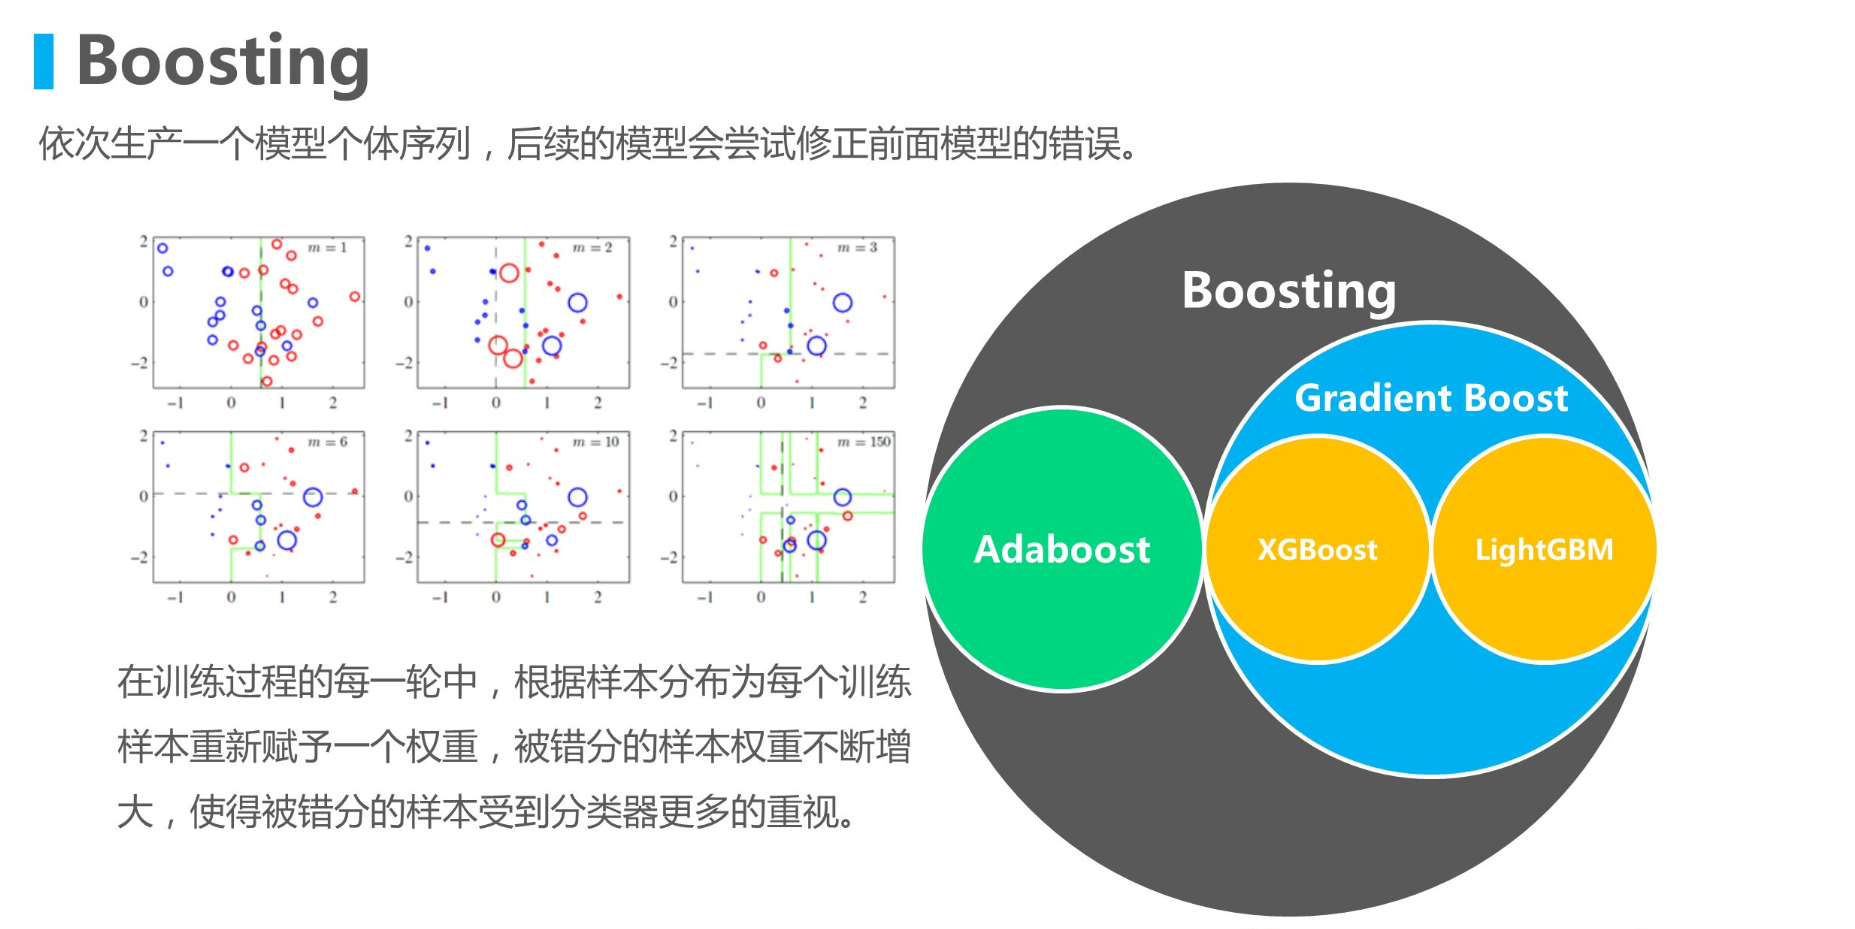

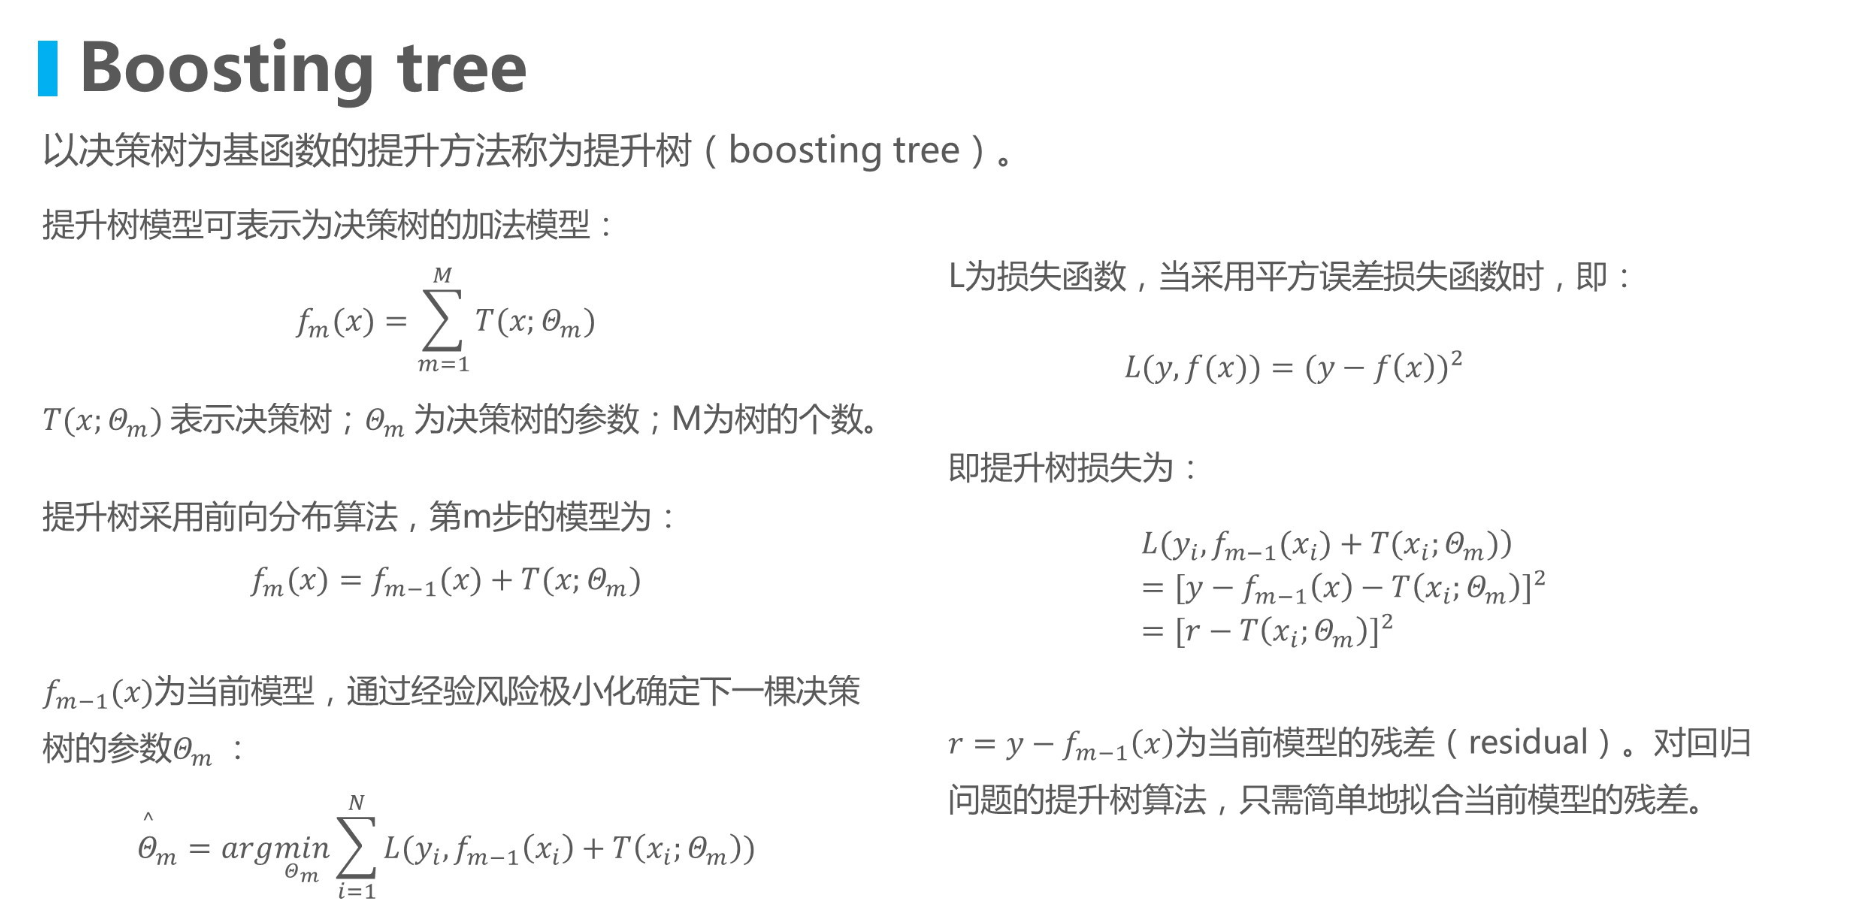

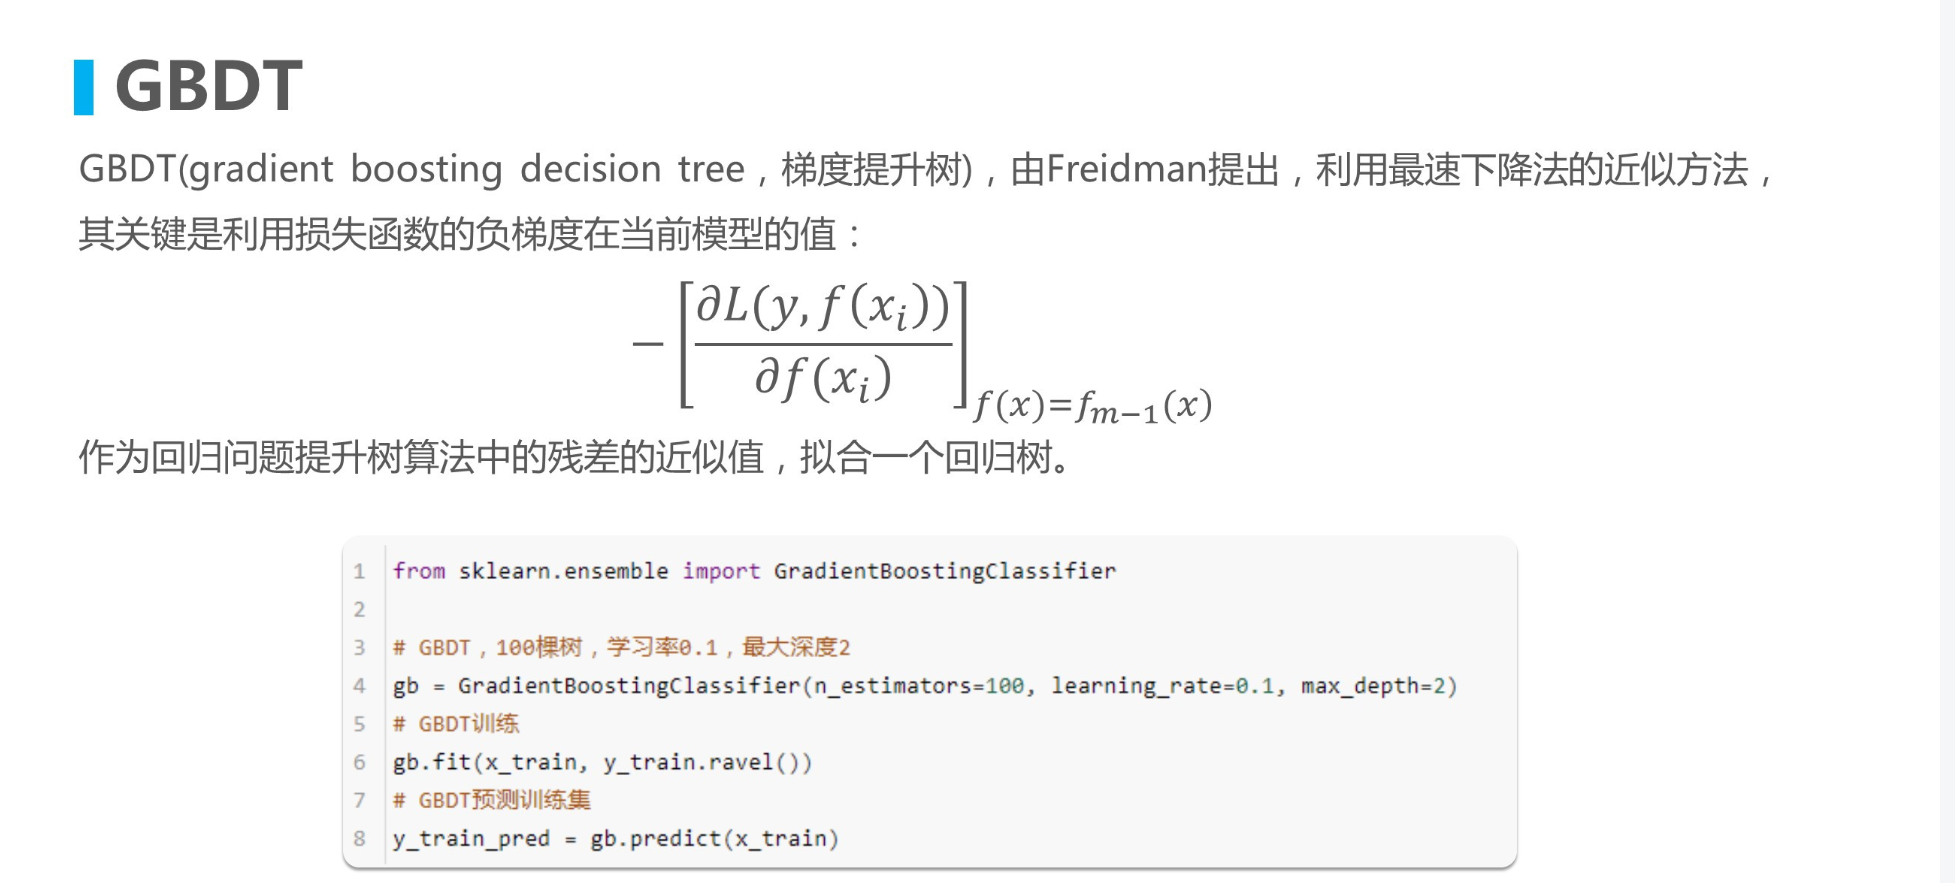

参考： https://blog.csdn.net/dkjkls/article/details/84675777

## 5.gbdt模型预估

核心代码

- 训练

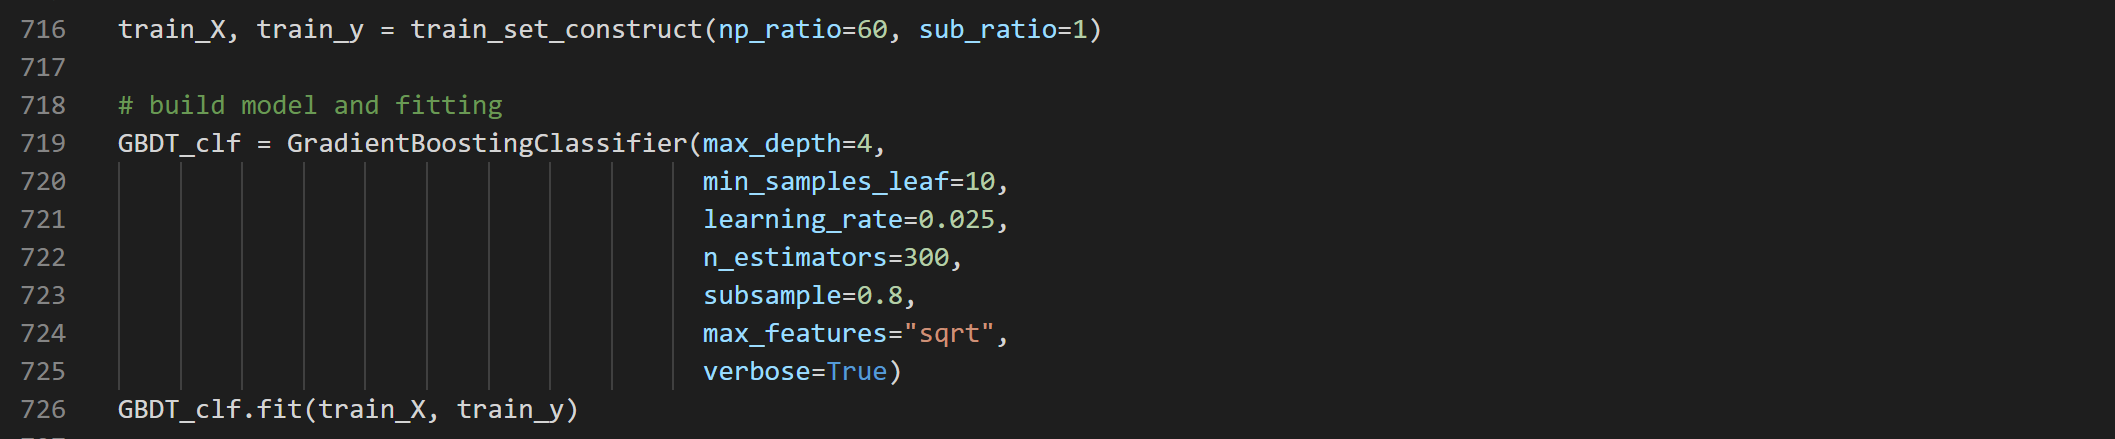

- 预估

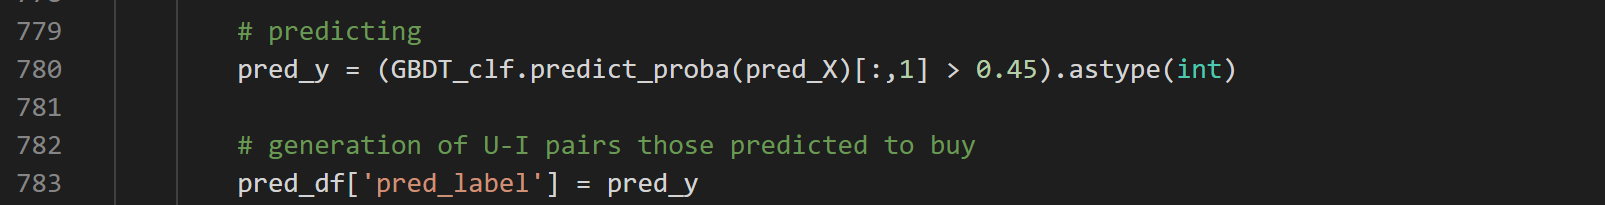

In [5]:
%run model\gbdt_on_subsample.py

training subset uic_label keys is selected.
train subset is generated.
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1578           0.0076           49.34s
         2           0.1517           0.0043           49.32s
         3           0.1484           0.0037           48.12s
         4           0.1481           0.0027           47.29s
         5           0.1432           0.0025           47.20s
         6           0.1423           0.0015           47.80s
         7           0.1413           0.0019           47.78s
         8           0.1372           0.0015           48.46s
         9           0.1368           0.0015           48.74s
        10           0.1355           0.0016           49.17s
        20           0.1248           0.0007           48.61s
        30           0.1186           0.0004           46.55s
        40           0.1170           0.0003           44.62s
        50           0.1141           0.0002           42.95

# GBDT

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [45]:
path_df_result = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/gbdt_res_gbdt_k_means_subsample.csv"
path_df_result_tmp = "/Users/DanDan/Desktop/第一课/code/fresh_comp_offline/k_means_subsample/gbdt_df_result_tmp.csv"

In [48]:
##### loading data of part 1 & 2
df_part_1_uic_label_cluster = df_read(path_df_part_1_uic_label_cluster)
df_part_2_uic_label_cluster = df_read(path_df_part_2_uic_label_cluster)

df_part_1_U  = df_read(path_df_part_1_U )   
df_part_1_I  = df_read(path_df_part_1_I )
df_part_1_C  = df_read(path_df_part_1_C )
df_part_1_IC = df_read(path_df_part_1_IC)
df_part_1_UI = df_read(path_df_part_1_UI)
df_part_1_UC = df_read(path_df_part_1_UC)

df_part_2_U  = df_read(path_df_part_2_U )   
df_part_2_I  = df_read(path_df_part_2_I )
df_part_2_C  = df_read(path_df_part_2_C )
df_part_2_IC = df_read(path_df_part_2_IC)
df_part_2_UI = df_read(path_df_part_2_UI)
df_part_2_UC = df_read(path_df_part_2_UC)

In [49]:
##### generation of training set & valid set
def train_set_construct(np_ratio = 1, sub_ratio = 1):
    '''
    # generation of train set
    @param np_ratio: int, the sub-sample rate of training set for N/P balanced.
    @param sub_ratio: float ~ (0~1], the further sub-sample rate of training set after N/P balanced.
    '''
    train_part_1_uic_label = df_part_1_uic_label_cluster[df_part_1_uic_label_cluster['class'] == 0].sample(frac = sub_ratio)
    train_part_2_uic_label = df_part_2_uic_label_cluster[df_part_2_uic_label_cluster['class'] == 0].sample(frac = sub_ratio)
    
    frac_ratio = sub_ratio * np_ratio/1200
    for i in range(1,1001,1):
        train_part_1_uic_label_0_i = df_part_1_uic_label_cluster[df_part_1_uic_label_cluster['class'] == i]
        train_part_1_uic_label_0_i = train_part_1_uic_label_0_i.sample(frac = frac_ratio)
        train_part_1_uic_label = pd.concat([train_part_1_uic_label, train_part_1_uic_label_0_i])
    
        train_part_2_uic_label_0_i = df_part_2_uic_label_cluster[df_part_2_uic_label_cluster['class'] == i]
        train_part_2_uic_label_0_i = train_part_2_uic_label_0_i.sample(frac = frac_ratio)
        train_part_2_uic_label = pd.concat([train_part_2_uic_label, train_part_2_uic_label_0_i])
    print("training subset uic_label keys is selected.")
    
    # constructing training set
    train_part_1_df = pd.merge(train_part_1_uic_label, df_part_1_U, how='left', on=['user_id'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_I,  how='left', on=['item_id'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_C,  how='left', on=['item_category'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_IC, how='left', on=['item_id','item_category'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_UI, how='left', on=['user_id','item_id','item_category','label'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_UC, how='left', on=['user_id','item_category'])
    
    train_part_2_df = pd.merge(train_part_2_uic_label, df_part_2_U, how='left', on=['user_id'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_I,  how='left', on=['item_id'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_C,  how='left', on=['item_category'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_IC, how='left', on=['item_id','item_category'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_UI, how='left', on=['user_id','item_id','item_category','label'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_UC, how='left', on=['user_id','item_category'])
    
    train_df = pd.concat([train_part_1_df, train_part_2_df])

    # fill the missing value as -1 (missing value are time features)
    train_df.fillna(-1, inplace=True)
    
    # using all the features for training gbdt model
    train_X = train_df[['u_b1_count_in_6','u_b2_count_in_6','u_b3_count_in_6','u_b4_count_in_6','u_b_count_in_6', 
                                  'u_b1_count_in_3','u_b2_count_in_3','u_b3_count_in_3','u_b4_count_in_3','u_b_count_in_3', 
                                  'u_b1_count_in_1','u_b2_count_in_1','u_b3_count_in_1','u_b4_count_in_1','u_b_count_in_1', 
                                  'u_b4_rate','u_b4_diff_hours',
                                  'i_u_count_in_6','i_u_count_in_3','i_u_count_in_1',
                                  'i_b1_count_in_6','i_b2_count_in_6','i_b3_count_in_6','i_b4_count_in_6','i_b_count_in_6', 
                                  'i_b1_count_in_3','i_b2_count_in_3','i_b3_count_in_3','i_b4_count_in_3','i_b_count_in_3',
                                  'i_b1_count_in_1','i_b2_count_in_1','i_b3_count_in_1','i_b4_count_in_1','i_b_count_in_1', 
                                  'i_b4_rate','i_b4_diff_hours',
                                  'c_u_count_in_6','c_u_count_in_3','c_u_count_in_1',
                                  'c_b1_count_in_6','c_b2_count_in_6','c_b3_count_in_6','c_b4_count_in_6','c_b_count_in_6',
                                  'c_b1_count_in_3','c_b2_count_in_3','c_b3_count_in_3','c_b4_count_in_3','c_b_count_in_3',
                                  'c_b1_count_in_1','c_b2_count_in_1','c_b3_count_in_1','c_b4_count_in_1','c_b_count_in_1',
                                  'c_b4_rate','c_b4_diff_hours',
                                  'ic_u_rank_in_c','ic_b_rank_in_c','ic_b4_rank_in_c', 
                                  'ui_b1_count_in_6','ui_b2_count_in_6','ui_b3_count_in_6','ui_b4_count_in_6','ui_b_count_in_6',
                                  'ui_b1_count_in_3','ui_b2_count_in_3','ui_b3_count_in_3','ui_b4_count_in_3','ui_b_count_in_3',
                                  'ui_b1_count_in_1','ui_b2_count_in_1','ui_b3_count_in_1','ui_b4_count_in_1','ui_b_count_in_1', 
                                  'ui_b_count_rank_in_u','ui_b_count_rank_in_uc',
                                  'ui_b1_last_hours','ui_b2_last_hours','ui_b3_last_hours','ui_b4_last_hours',
                                  'uc_b1_count_in_6','uc_b2_count_in_6','uc_b3_count_in_6','uc_b4_count_in_6','uc_b_count_in_6', 
                                  'uc_b1_count_in_3','uc_b2_count_in_3','uc_b3_count_in_3','uc_b4_count_in_3','uc_b_count_in_3', 
                                  'uc_b1_count_in_1','uc_b2_count_in_1','uc_b3_count_in_1','uc_b4_count_in_1','uc_b_count_in_1',
                                  'uc_b_count_rank_in_u',
                                  'uc_b1_last_hours','uc_b2_last_hours','uc_b3_last_hours','uc_b4_last_hours']].values
    train_y = train_df['label'].values
    print("train subset is generated.")
    return train_X, train_y
    
def valid_set_construct(sub_ratio = 0.1):
    '''
    # generation of valid set
    @param sub_ratio: float ~ (0~1], the sub-sample rate of original valid set
    '''
    valid_part_1_uic_label = df_part_1_uic_label_cluster[df_part_1_uic_label_cluster['class'] == 0].sample(frac = sub_ratio)
    valid_part_2_uic_label = df_part_2_uic_label_cluster[df_part_2_uic_label_cluster['class'] == 0].sample(frac = sub_ratio)

    for i in range(1,1001,1):
        valid_part_1_uic_label_0_i = df_part_1_uic_label_cluster[df_part_1_uic_label_cluster['class'] == i]
        valid_part_1_uic_label_0_i = valid_part_1_uic_label_0_i.sample(frac = sub_ratio)
        valid_part_1_uic_label = pd.concat([valid_part_1_uic_label, valid_part_1_uic_label_0_i])
    
        valid_part_2_uic_label_0_i = df_part_2_uic_label_cluster[df_part_2_uic_label_cluster['class'] == i]
        valid_part_2_uic_label_0_i = valid_part_2_uic_label_0_i.sample(frac = sub_ratio)
        valid_part_2_uic_label = pd.concat([valid_part_2_uic_label, valid_part_2_uic_label_0_i])
    
    # constructing valid set
    valid_part_1_df = pd.merge(valid_part_1_uic_label, df_part_1_U, how='left', on=['user_id'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_I,  how='left', on=['item_id'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_C,  how='left', on=['item_category'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_IC, how='left', on=['item_id','item_category'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_UI, how='left', on=['user_id','item_id','item_category','label'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_UC, how='left', on=['user_id','item_category'])
    
    valid_part_2_df = pd.merge(valid_part_2_uic_label, df_part_2_U, how='left', on=['user_id'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_I,  how='left', on=['item_id'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_C,  how='left', on=['item_category'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_IC, how='left', on=['item_id','item_category'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_UI, how='left', on=['user_id','item_id','item_category','label'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_UC, how='left', on=['user_id','item_category'])
    
    valid_df = pd.concat([valid_part_1_df, valid_part_2_df])

    # fill the missing value as -1 (missing value are time features)
    valid_df.fillna(-1, inplace=True)
    
    # using all the features for valid gbdt model
    valid_X = valid_df[['u_b1_count_in_6','u_b2_count_in_6','u_b3_count_in_6','u_b4_count_in_6','u_b_count_in_6', 
                                  'u_b1_count_in_3','u_b2_count_in_3','u_b3_count_in_3','u_b4_count_in_3','u_b_count_in_3', 
                                  'u_b1_count_in_1','u_b2_count_in_1','u_b3_count_in_1','u_b4_count_in_1','u_b_count_in_1', 
                                  'u_b4_rate','u_b4_diff_hours',
                                  'i_u_count_in_6','i_u_count_in_3','i_u_count_in_1',
                                  'i_b1_count_in_6','i_b2_count_in_6','i_b3_count_in_6','i_b4_count_in_6','i_b_count_in_6', 
                                  'i_b1_count_in_3','i_b2_count_in_3','i_b3_count_in_3','i_b4_count_in_3','i_b_count_in_3',
                                  'i_b1_count_in_1','i_b2_count_in_1','i_b3_count_in_1','i_b4_count_in_1','i_b_count_in_1', 
                                  'i_b4_rate','i_b4_diff_hours',
                                  'c_u_count_in_6','c_u_count_in_3','c_u_count_in_1',
                                  'c_b1_count_in_6','c_b2_count_in_6','c_b3_count_in_6','c_b4_count_in_6','c_b_count_in_6',
                                  'c_b1_count_in_3','c_b2_count_in_3','c_b3_count_in_3','c_b4_count_in_3','c_b_count_in_3',
                                  'c_b1_count_in_1','c_b2_count_in_1','c_b3_count_in_1','c_b4_count_in_1','c_b_count_in_1',
                                  'c_b4_rate','c_b4_diff_hours',
                                  'ic_u_rank_in_c','ic_b_rank_in_c','ic_b4_rank_in_c', 
                                  'ui_b1_count_in_6','ui_b2_count_in_6','ui_b3_count_in_6','ui_b4_count_in_6','ui_b_count_in_6',
                                  'ui_b1_count_in_3','ui_b2_count_in_3','ui_b3_count_in_3','ui_b4_count_in_3','ui_b_count_in_3',
                                  'ui_b1_count_in_1','ui_b2_count_in_1','ui_b3_count_in_1','ui_b4_count_in_1','ui_b_count_in_1', 
                                  'ui_b_count_rank_in_u','ui_b_count_rank_in_uc',
                                  'ui_b1_last_hours','ui_b2_last_hours','ui_b3_last_hours','ui_b4_last_hours',
                                  'uc_b1_count_in_6','uc_b2_count_in_6','uc_b3_count_in_6','uc_b4_count_in_6','uc_b_count_in_6', 
                                  'uc_b1_count_in_3','uc_b2_count_in_3','uc_b3_count_in_3','uc_b4_count_in_3','uc_b_count_in_3', 
                                  'uc_b1_count_in_1','uc_b2_count_in_1','uc_b3_count_in_1','uc_b4_count_in_1','uc_b_count_in_1',
                                  'uc_b_count_rank_in_u',
                                  'uc_b1_last_hours','uc_b2_last_hours','uc_b3_last_hours','uc_b4_last_hours']].values
    valid_y = valid_df['label'].values
    print("valid subset is generated.")
    return valid_X, valid_y


##### generation and splitting to training set & valid set
def valid_train_set_construct(valid_ratio = 0.5, valid_sub_ratio = 0.5, train_np_ratio = 1, train_sub_ratio = 0.5):
    '''
    # generation of train set
    @param valid_ratio: float ~ [0~1], the valid set ratio in total set and the rest is train set
    @param valid_sub_ratio: float ~ (0~1), random sample ratio of valid set
    @param train_np_ratio:(1~1200), the sub-sample ratio of training set for N/P balanced.
    @param train_sub_ratio: float ~ (0~1), random sample ratio of train set after N/P subsample
    
    @return valid_X, valid_y, train_X, train_y
    '''
    msk_1 = np.random.rand(len(df_part_1_uic_label_cluster)) < valid_ratio
    msk_2 = np.random.rand(len(df_part_2_uic_label_cluster)) < valid_ratio
        
    valid_df_part_1_uic_label_cluster = df_part_1_uic_label_cluster.loc[msk_1]
    valid_df_part_2_uic_label_cluster = df_part_2_uic_label_cluster.loc[msk_2]
    
    valid_part_1_uic_label = valid_df_part_1_uic_label_cluster[ valid_df_part_1_uic_label_cluster['class'] == 0 ].sample(frac = valid_sub_ratio)
    valid_part_2_uic_label = valid_df_part_2_uic_label_cluster[ valid_df_part_2_uic_label_cluster['class'] == 0 ].sample(frac = valid_sub_ratio)
    
    ### constructing valid set
    for i in range(1,1001,1):
        valid_part_1_uic_label_0_i = valid_df_part_1_uic_label_cluster[valid_df_part_1_uic_label_cluster['class'] == i]
        if len(valid_part_1_uic_label_0_i) != 0:
            valid_part_1_uic_label_0_i = valid_part_1_uic_label_0_i.sample(frac = valid_sub_ratio)
            valid_part_1_uic_label     = pd.concat([valid_part_1_uic_label, valid_part_1_uic_label_0_i])
        
        valid_part_2_uic_label_0_i = valid_df_part_2_uic_label_cluster[valid_df_part_2_uic_label_cluster['class'] == i]
        if len(valid_part_2_uic_label_0_i) != 0:
            valid_part_2_uic_label_0_i = valid_part_2_uic_label_0_i.sample(frac = valid_sub_ratio)
            valid_part_2_uic_label     = pd.concat([valid_part_2_uic_label, valid_part_2_uic_label_0_i])
    
    valid_part_1_df = pd.merge(valid_part_1_uic_label, df_part_1_U, how='left', on=['user_id'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_I,  how='left', on=['item_id'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_C,  how='left', on=['item_category'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_IC, how='left', on=['item_id','item_category'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_UI, how='left', on=['user_id','item_id','item_category','label'])
    valid_part_1_df = pd.merge(valid_part_1_df, df_part_1_UC, how='left', on=['user_id','item_category'])
    
    valid_part_2_df = pd.merge(valid_part_2_uic_label, df_part_2_U, how='left', on=['user_id'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_I,  how='left', on=['item_id'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_C,  how='left', on=['item_category'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_IC, how='left', on=['item_id','item_category'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_UI, how='left', on=['user_id','item_id','item_category','label'])
    valid_part_2_df = pd.merge(valid_part_2_df, df_part_2_UC, how='left', on=['user_id','item_category'])
    
    valid_df = pd.concat([valid_part_1_df, valid_part_2_df])

    # fill the missing value as -1 (missing value are time features)
    valid_df.fillna(-1, inplace=True)
    
    # using all the features for valid rf model
    valid_X = valid_df[['u_b1_count_in_6','u_b2_count_in_6','u_b3_count_in_6','u_b4_count_in_6','u_b_count_in_6', 
                                  'u_b1_count_in_3','u_b2_count_in_3','u_b3_count_in_3','u_b4_count_in_3','u_b_count_in_3', 
                                  'u_b1_count_in_1','u_b2_count_in_1','u_b3_count_in_1','u_b4_count_in_1','u_b_count_in_1', 
                                  'u_b4_rate','u_b4_diff_hours',
                                  'i_u_count_in_6','i_u_count_in_3','i_u_count_in_1',
                                  'i_b1_count_in_6','i_b2_count_in_6','i_b3_count_in_6','i_b4_count_in_6','i_b_count_in_6', 
                                  'i_b1_count_in_3','i_b2_count_in_3','i_b3_count_in_3','i_b4_count_in_3','i_b_count_in_3',
                                  'i_b1_count_in_1','i_b2_count_in_1','i_b3_count_in_1','i_b4_count_in_1','i_b_count_in_1', 
                                  'i_b4_rate','i_b4_diff_hours',
                                  'c_u_count_in_6','c_u_count_in_3','c_u_count_in_1',
                                  'c_b1_count_in_6','c_b2_count_in_6','c_b3_count_in_6','c_b4_count_in_6','c_b_count_in_6',
                                  'c_b1_count_in_3','c_b2_count_in_3','c_b3_count_in_3','c_b4_count_in_3','c_b_count_in_3',
                                  'c_b1_count_in_1','c_b2_count_in_1','c_b3_count_in_1','c_b4_count_in_1','c_b_count_in_1',
                                  'c_b4_rate','c_b4_diff_hours',
                                  'ic_u_rank_in_c','ic_b_rank_in_c','ic_b4_rank_in_c', 
                                  'ui_b1_count_in_6','ui_b2_count_in_6','ui_b3_count_in_6','ui_b4_count_in_6','ui_b_count_in_6',
                                  'ui_b1_count_in_3','ui_b2_count_in_3','ui_b3_count_in_3','ui_b4_count_in_3','ui_b_count_in_3',
                                  'ui_b1_count_in_1','ui_b2_count_in_1','ui_b3_count_in_1','ui_b4_count_in_1','ui_b_count_in_1', 
                                  'ui_b_count_rank_in_u','ui_b_count_rank_in_uc',
                                  'ui_b1_last_hours','ui_b2_last_hours','ui_b3_last_hours','ui_b4_last_hours',
                                  'uc_b1_count_in_6','uc_b2_count_in_6','uc_b3_count_in_6','uc_b4_count_in_6','uc_b_count_in_6', 
                                  'uc_b1_count_in_3','uc_b2_count_in_3','uc_b3_count_in_3','uc_b4_count_in_3','uc_b_count_in_3', 
                                  'uc_b1_count_in_1','uc_b2_count_in_1','uc_b3_count_in_1','uc_b4_count_in_1','uc_b_count_in_1',
                                  'uc_b_count_rank_in_u',
                                  'uc_b1_last_hours','uc_b2_last_hours','uc_b3_last_hours','uc_b4_last_hours']].values
    valid_y = valid_df['label'].values
    print("valid subset is generated.")

    ### constructing training set
    train_df_part_1_uic_label_cluster = df_part_1_uic_label_cluster.loc[~msk_1]
    train_df_part_2_uic_label_cluster = df_part_2_uic_label_cluster.loc[~msk_2] 
    
    train_part_1_uic_label = train_df_part_1_uic_label_cluster[ train_df_part_1_uic_label_cluster['class'] == 0 ].sample(frac = train_sub_ratio)
    train_part_2_uic_label = train_df_part_2_uic_label_cluster[ train_df_part_2_uic_label_cluster['class'] == 0 ].sample(frac = train_sub_ratio)
    
    frac_ratio = train_sub_ratio * train_np_ratio/1200
    for i in range(1,1001,1):
        train_part_1_uic_label_0_i = train_df_part_1_uic_label_cluster[train_df_part_1_uic_label_cluster['class'] == i]
        if len(train_part_1_uic_label_0_i) != 0:
            train_part_1_uic_label_0_i = train_part_1_uic_label_0_i.sample(frac = frac_ratio)
            train_part_1_uic_label = pd.concat([train_part_1_uic_label, train_part_1_uic_label_0_i])
    
        train_part_2_uic_label_0_i = train_df_part_2_uic_label_cluster[train_df_part_2_uic_label_cluster['class'] == i]
        if len(train_part_2_uic_label_0_i) != 0:
            train_part_2_uic_label_0_i = train_part_2_uic_label_0_i.sample(frac = frac_ratio)
            train_part_2_uic_label = pd.concat([train_part_2_uic_label, train_part_2_uic_label_0_i])
    
    # constructing training set
    train_part_1_df = pd.merge(train_part_1_uic_label, df_part_1_U, how='left', on=['user_id'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_I,  how='left', on=['item_id'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_C,  how='left', on=['item_category'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_IC, how='left', on=['item_id','item_category'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_UI, how='left', on=['user_id','item_id','item_category','label'])
    train_part_1_df = pd.merge(train_part_1_df, df_part_1_UC, how='left', on=['user_id','item_category'])
    
    train_part_2_df = pd.merge(train_part_2_uic_label, df_part_2_U, how='left', on=['user_id'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_I,  how='left', on=['item_id'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_C,  how='left', on=['item_category'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_IC, how='left', on=['item_id','item_category'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_UI, how='left', on=['user_id','item_id','item_category','label'])
    train_part_2_df = pd.merge(train_part_2_df, df_part_2_UC, how='left', on=['user_id','item_category'])
    
    train_df = pd.concat([train_part_1_df, train_part_2_df])

    # fill the missing value as -1 (missing value are time features)
    train_df.fillna(-1, inplace=True)
    
    # using all the features for training rf model
    train_X = train_df[['u_b1_count_in_6','u_b2_count_in_6','u_b3_count_in_6','u_b4_count_in_6','u_b_count_in_6', 
                                  'u_b1_count_in_3','u_b2_count_in_3','u_b3_count_in_3','u_b4_count_in_3','u_b_count_in_3', 
                                  'u_b1_count_in_1','u_b2_count_in_1','u_b3_count_in_1','u_b4_count_in_1','u_b_count_in_1', 
                                  'u_b4_rate','u_b4_diff_hours',
                                  'i_u_count_in_6','i_u_count_in_3','i_u_count_in_1',
                                  'i_b1_count_in_6','i_b2_count_in_6','i_b3_count_in_6','i_b4_count_in_6','i_b_count_in_6', 
                                  'i_b1_count_in_3','i_b2_count_in_3','i_b3_count_in_3','i_b4_count_in_3','i_b_count_in_3',
                                  'i_b1_count_in_1','i_b2_count_in_1','i_b3_count_in_1','i_b4_count_in_1','i_b_count_in_1', 
                                  'i_b4_rate','i_b4_diff_hours',
                                  'c_u_count_in_6','c_u_count_in_3','c_u_count_in_1',
                                  'c_b1_count_in_6','c_b2_count_in_6','c_b3_count_in_6','c_b4_count_in_6','c_b_count_in_6',
                                  'c_b1_count_in_3','c_b2_count_in_3','c_b3_count_in_3','c_b4_count_in_3','c_b_count_in_3',
                                  'c_b1_count_in_1','c_b2_count_in_1','c_b3_count_in_1','c_b4_count_in_1','c_b_count_in_1',
                                  'c_b4_rate','c_b4_diff_hours',
                                  'ic_u_rank_in_c','ic_b_rank_in_c','ic_b4_rank_in_c', 
                                  'ui_b1_count_in_6','ui_b2_count_in_6','ui_b3_count_in_6','ui_b4_count_in_6','ui_b_count_in_6',
                                  'ui_b1_count_in_3','ui_b2_count_in_3','ui_b3_count_in_3','ui_b4_count_in_3','ui_b_count_in_3',
                                  'ui_b1_count_in_1','ui_b2_count_in_1','ui_b3_count_in_1','ui_b4_count_in_1','ui_b_count_in_1', 
                                  'ui_b_count_rank_in_u','ui_b_count_rank_in_uc',
                                  'ui_b1_last_hours','ui_b2_last_hours','ui_b3_last_hours','ui_b4_last_hours',
                                  'uc_b1_count_in_6','uc_b2_count_in_6','uc_b3_count_in_6','uc_b4_count_in_6','uc_b_count_in_6', 
                                  'uc_b1_count_in_3','uc_b2_count_in_3','uc_b3_count_in_3','uc_b4_count_in_3','uc_b_count_in_3', 
                                  'uc_b1_count_in_1','uc_b2_count_in_1','uc_b3_count_in_1','uc_b4_count_in_1','uc_b_count_in_1',
                                  'uc_b_count_rank_in_u',
                                  'uc_b1_last_hours','uc_b2_last_hours','uc_b3_last_hours','uc_b4_last_hours']].values
    train_y = train_df['label'].values
    print("train subset is generated.")
    
    return valid_X, valid_y, train_X, train_y

In [50]:
#######################################################################
'''Step 2: training the optimal GBDT model and predicting on part_3 
'''
train_X, train_y = train_set_construct(np_ratio=60, sub_ratio=1)

# build model and fitting
GBDT_clf = GradientBoostingClassifier(max_depth=4,
                                      min_samples_leaf=10,
                                      learning_rate=0.025,
                                      n_estimators=300,
                                      subsample=0.8,
                                      max_features="sqrt",
                                      verbose=True)
GBDT_clf.fit(train_X, train_y)

##### predicting
# loading feature data
df_part_3_U  = df_read(path_df_part_3_U )   
df_part_3_I  = df_read(path_df_part_3_I )
df_part_3_C  = df_read(path_df_part_3_C )
df_part_3_IC = df_read(path_df_part_3_IC)
df_part_3_UI = df_read(path_df_part_3_UI)
df_part_3_UC = df_read(path_df_part_3_UC)

# process by chunk as ui-pairs size is too big
batch = 0
for pred_uic in pd.read_csv(open(path_df_part_3_uic, 'r'), chunksize = 100000): 
    try:     
        # construct of prediction sample set
        pred_df = pd.merge(pred_uic, df_part_3_U,  how='left', on=['user_id'])
        pred_df = pd.merge(pred_df,  df_part_3_I,  how='left', on=['item_id'])
        pred_df = pd.merge(pred_df,  df_part_3_C,  how='left', on=['item_category'])
        pred_df = pd.merge(pred_df,  df_part_3_IC, how='left', on=['item_id','item_category'])
        pred_df = pd.merge(pred_df,  df_part_3_UI, how='left', on=['user_id','item_id','item_category'])
        pred_df = pd.merge(pred_df,  df_part_3_UC, how='left', on=['user_id','item_category'])

        # fill the missing value as -1 (missing value are time features)
        pred_df.fillna(-1, inplace=True)
        
        # using all the features for training RF model
        pred_X = pred_df[['u_b1_count_in_6','u_b2_count_in_6','u_b3_count_in_6','u_b4_count_in_6','u_b_count_in_6', 
                                    'u_b1_count_in_3','u_b2_count_in_3','u_b3_count_in_3','u_b4_count_in_3','u_b_count_in_3', 
                                    'u_b1_count_in_1','u_b2_count_in_1','u_b3_count_in_1','u_b4_count_in_1','u_b_count_in_1', 
                                    'u_b4_rate','u_b4_diff_hours',
                                    'i_u_count_in_6','i_u_count_in_3','i_u_count_in_1',
                                    'i_b1_count_in_6','i_b2_count_in_6','i_b3_count_in_6','i_b4_count_in_6','i_b_count_in_6', 
                                    'i_b1_count_in_3','i_b2_count_in_3','i_b3_count_in_3','i_b4_count_in_3','i_b_count_in_3',
                                    'i_b1_count_in_1','i_b2_count_in_1','i_b3_count_in_1','i_b4_count_in_1','i_b_count_in_1', 
                                    'i_b4_rate','i_b4_diff_hours',
                                    'c_u_count_in_6','c_u_count_in_3','c_u_count_in_1',
                                    'c_b1_count_in_6','c_b2_count_in_6','c_b3_count_in_6','c_b4_count_in_6','c_b_count_in_6',
                                    'c_b1_count_in_3','c_b2_count_in_3','c_b3_count_in_3','c_b4_count_in_3','c_b_count_in_3',
                                    'c_b1_count_in_1','c_b2_count_in_1','c_b3_count_in_1','c_b4_count_in_1','c_b_count_in_1',
                                    'c_b4_rate','c_b4_diff_hours',
                                    'ic_u_rank_in_c','ic_b_rank_in_c','ic_b4_rank_in_c', 
                                    'ui_b1_count_in_6','ui_b2_count_in_6','ui_b3_count_in_6','ui_b4_count_in_6','ui_b_count_in_6',
                                    'ui_b1_count_in_3','ui_b2_count_in_3','ui_b3_count_in_3','ui_b4_count_in_3','ui_b_count_in_3',
                                    'ui_b1_count_in_1','ui_b2_count_in_1','ui_b3_count_in_1','ui_b4_count_in_1','ui_b_count_in_1', 
                                    'ui_b_count_rank_in_u','ui_b_count_rank_in_uc',
                                    'ui_b1_last_hours','ui_b2_last_hours','ui_b3_last_hours','ui_b4_last_hours',
                                    'uc_b1_count_in_6','uc_b2_count_in_6','uc_b3_count_in_6','uc_b4_count_in_6','uc_b_count_in_6', 
                                    'uc_b1_count_in_3','uc_b2_count_in_3','uc_b3_count_in_3','uc_b4_count_in_3','uc_b_count_in_3', 
                                    'uc_b1_count_in_1','uc_b2_count_in_1','uc_b3_count_in_1','uc_b4_count_in_1','uc_b_count_in_1',
                                    'uc_b_count_rank_in_u',
                                    'uc_b1_last_hours','uc_b2_last_hours','uc_b3_last_hours','uc_b4_last_hours']].values

        # predicting
        pred_y = (GBDT_clf.predict_proba(pred_X)[:,1] > 0.45).astype(int)

        # generation of U-I pairs those predicted to buy
        pred_df['pred_label'] = pred_y
        # add to result csv
        pred_df[pred_df['pred_label'] == 1].to_csv(path_df_result_tmp, 
                                                   columns=['user_id','item_id'],
                                                   index=False, header=False, mode='a')
        
        batch += 1
        print("prediction chunk %d done." % batch) 
        
    except StopIteration:
        print("prediction finished.")
        break         

training subset uic_label keys is selected.
train subset is generated.
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1569           0.0058            1.98m
         2           0.1547           0.0040            1.86m
         3           0.1491           0.0038            1.79m
         4           0.1492           0.0025            1.69m
         5           0.1472           0.0020            1.67m
         6           0.1443           0.0020            1.65m
         7           0.1424           0.0017            1.61m
         8           0.1416           0.0017            1.59m
         9           0.1375           0.0016            1.57m
        10           0.1372           0.0013            1.55m
        20           0.1258           0.0008            1.48m
        30           0.1218           0.0005            1.41m
        40           0.1162           0.0003            1.34m
        50           0.1154           0.0002            1.28

In [51]:
#######################################################################
'''Step 3: generation result on items' sub set P 
'''
# loading data
df_P = df_read(path_df_P)
df_P_item = df_P.drop_duplicates(['item_id'])[['item_id']]
df_pred = pd.read_csv(open(path_df_result_tmp,'r'), index_col=False, header=None)
df_pred.columns = ['user_id', 'item_id']

# output result
df_pred_P = pd.merge(df_pred, df_P_item, on=['item_id'], how='inner')[['user_id', 'item_id']]
df_pred_P.to_csv(path_df_result, index=False)

print(' Finished ')

 Finished 


##### 提交到天池平台后得分 0.10321 ，不错的结果！！

##### gbdt调参经验
GBDT在训练时也需要进行大量的参数调节工作，以期获得适合于当前数据任务的模型。这里依然将GBDT的参数分为过程参数和基学习器参数两类，首先调节过程参数（学习率、基学习器个数等），然后调节基学习器参数（树深度、叶子分裂样本数等），推荐采用启发贪心式的参数调节方法，反复调节以期得到较好的参数组合。下面是对一些重要参数的讨论：

###### (1) N/P_ratio（负正样本比例）

考虑到过量冗余的负样本会严重加大训练消耗，考虑在不影响样本信息充分性的前提下对数据进行采样。

###### (2) learning_rate（学习率）/n_estimators（基学习器数目）

这里，learning_rate 和 n_estimators 分别控制迭代的步长和最大迭代次数，所以，这两个参数应当一起调试，寻找最优的组合。GBDT设置大量基学习器的目的是为了集成来降低偏差，所以 n_estimators 一般会设置得大一些。

下图示为某次参数调节过程中验证集 f1_score 在不同 learning_rate 取值下随 n_estimators 的变化曲线。从图中可以看出，过大学习率导致拟合效果很差甚至出现发散，过小的学习率导致拟合太慢；另外我们可以看出，当迭代达到一定次数时，继续迭代对模型提升效果不大，据此可选择出一个合适的n_estimators取值。

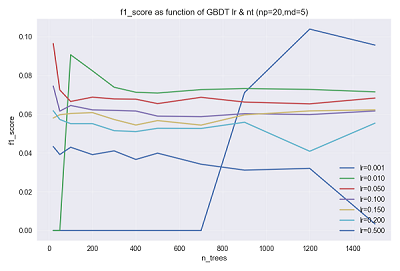



###### (3) max_depth（树深度）

对于GBDT模型来说，其每个基学习器是一个弱学习器，决策树的深度一般设置得比较小，以此来降低方差，之后在经过残差逼近迭代来降低偏差，从而形成强学习器。所以不同于随机森林模型，这里的 max_depth 参数值应设置得比较小

下图示为某次参数调节过程中验证集 f1_score 随 max_depth 的变化曲线。
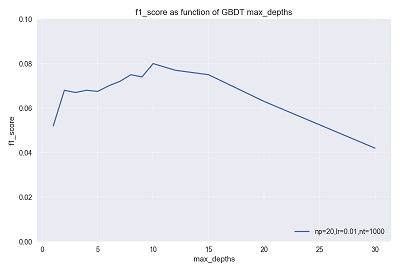

###### (4) min_samples_split（划分样本数）/min_samples_leaf(叶最小样本数)

在GBDT中，单个基学习器侧重于降低方差，其叶节点粒度应该比较粗，所以这两个参数应设置得较大，但同时要考虑到数据失衡的情况，所以又不能设置得过大。

下图示为某次参数调节过程中验证集 f1_score 随 min_samples_leaf 的变化曲线。
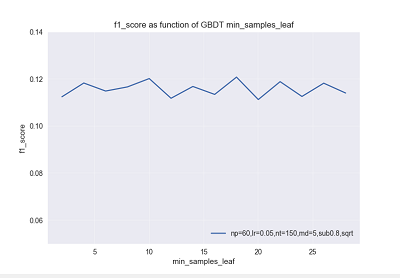

###### (5) cut_off（预测概率阈值）

同随机森林中该项参数一致，cut_off 控制着我们对结果的置信程度。下图示为某次参数调节过程中验证集 f1_score 随 cut_off 的变化曲线，可以看出，当前参数设定下的训练器，取 cut_off ~ [0.4，0.6]比较合适，（p.s.cut_off分布较对称且矮胖得出来的结果比较稳定）。

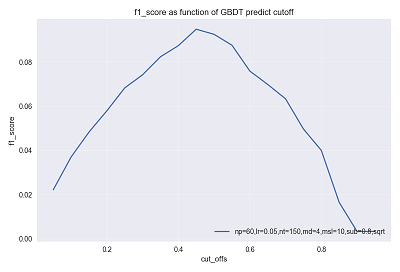

除了上述参数之外，在一般调参的过程中还需要考虑的参数有：参考随机森林引入特征随机性的参数 max_features ，控制叶节点分裂粒度的参数 min_samples_split、min_samples_leaf 等。

## 6.结果总结

1.过程回顾

- 任务被确立为基于模型的二分类，总体任务明确为是：分类模型套用 + 参数调节。

- 采用最简单的逻辑斯蒂回归（LR）进行了训练与预测，效果很差，进一步验证了数据随机性强、非线性的问题。

- 采用主流的集成学习方法梯度提升树（GBDT）进行了训练与预测，效果提升明显，说明这种树集成的模型对工程实践中的随机性、非线性强，的数据适应性好。

2.关于参数调节

在采用集成学习模型GBDT时，参数优化对模型效果的提升十分明显，但是最优参数的获取往往是一个NP难题，故而采用启发式的贪婪搜索是一个相对好的选择。

对于集成模型，我们将其参数分为过程参数和基学习器参数两种，根据其对模型性能影响大小的经验判断来依次对其进行优化，不断的迭代往复进行直到获得一个满足要求的参数组合（一般是局部最优）。注意在整个过程中对拟合程度的把握，防止欠拟合/过拟合，拟合程度可根据训练过程中的训练损失（Train loss）、袋外估计（OOB），验证过程中的f1分数变化曲线等信息结合经验判断。

3.其他

考虑到模型训练的效率以及对数据信息的学习能力，下一步拟采用DNN模型以期更好地实现当前任务。